# Word Evolution 

This Notebook contains all code necessary to **visualise word evolutions** for **any key words** contained in a corpus of text. \
\
The method constructs **word2vec models** based on yearly subsets of the text corpus. \
\
For each year a new Word2Vec model is trained. \
\
By comparing word similarities across the years, the evolution of the chosen key word can be found by demonstrating the changing context of the word.  \
\
**To demonstrate**, the evolution of the word **"Uncertainty"** is shown for all of **Danske Banks annual and quarterly reports spanning 2012 to 2020**.\
\
"Uncertainty" is a word frequently used in Danske Bank's Reports, to address both macroeconomic conditions and individual challenges the bank is facing. In this situation, word evolution can be interpreted as Danske Bank's changing perception of the risks facing the bank.\
\
**Key Takeaways:**

- **Words related to uncertainty is shown for each year**
- **The context changes**
- **Uncertainty in 2012 is caused by the european debt crisis**
- **in 2016 the brexit referendum is the main cause of uncertainty**
- **2018, 2019, 2020 is both affected by brexit**
- **in 2019 the investigation into estonia branch is a cause of uncertainty**
- **2020 is, as expected, heavily affected by the Covid-19 pandemic**





![alt text](Word_evolution_uncertainty.png "Title")

In [45]:
from tqdm.notebook import tqdm
import numpy as np
import spacy
from datetime import datetime
from time import time
from collections import defaultdict
import pandas as pd
import networkx as nx
import re
# Text is exciting:
from os.path import join
from gensim.models import Word2Vec
import multiprocessing
import nltk 
nltk.download('punkt')
from nltk import tokenize
from functools import reduce
import pickle
from matplotlib.pyplot import plot, scatter
import matplotlib.pyplot as plt
# default setting for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Class for extracting file paths from a destination

In [3]:
class corpora:
    import os
    
    def __init__(self, location):
        """
        :param location: path where pdfs to be converted is located
        :type location: str
        :param destination: path where txt files is saved
        :type destination: str
        """
        self.location = location
        self.path = None
        self.files = None
        
        if self.location is not None:
            self.get_locations()


    def get_locations(self):
        if self.location is not None:
            self.path, self.files = self.get_files_in_location(self.location)
            
            print("found " + str(len(self.files))+ " files in " + str(self.path))
            

    @staticmethod
    def get_files_in_location(location):
        from os import listdir
        from os.path import isfile, join, expanduser
        
        mypath=expanduser('~') +'\\' + location
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        return mypath, onlyfiles
        
    

### Defining a class model preprocessing and training

In [9]:
class v2w_model():
    from gensim.models import Word2Vec
    import os
    from gensim.models.phrases import Phrases, Phraser  #, ENGLISH_CONNECTOR_WORDS -- Connector words does not exist?

    
    def __init__(self, data):
        """
        :param data: DataFrame containing sentences of data
        :type location: DataFrame
        """
        self.data = data
        self.data_clean = None
        self.model = None
        self.sentences = None
        
    def preprocess_build_train_model(self, min_count_p = 30, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative = 20, progress_per = 10000, epochs=30, report_delay=1, threshold=1, connector_words = None):
        #self, min_count_p = 30, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative = 20, progress_per = 10000, epochs=30, report_delay=1
        self.preprocess(min_count_p, threshold, connector_words, progress_per)
        self.define_model(min_count, window, size, sample, alpha, min_alpha, negative)
        self.build_vocab(progress_per)
        self.train_model(epochs, report_delay)

    def preprocess(self, min_count_p, threshold, connector_words, progress_per):
        from gensim.models.phrases import Phrases, Phraser

        nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
        
        brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in self.data['Text'])

        t = time()

        txt = [self.cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

        print('Time to clean up everything: {} seconds'.format(round((time() - t) , 2)))
        
        df_clean = pd.DataFrame({'Period': self.data.Period,'clean': txt})
        df_clean = df_clean.dropna().drop_duplicates()
        
        self.data_clean = df_clean
        
        sent = [row.split() for row in df_clean['clean']]
        phrases = Phrases(sent, min_count_p, threshold=threshold, progress_per=progress_per) #connector_words not woriking

        bigram = Phraser(phrases)
        self.sentences = bigram[sent]
        
    def define_model(self, min_count, window, size, sample, alpha, min_alpha, negative):
        
        import logging  # Setting up the loggings to monitor gensim
        logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
        
        cores = multiprocessing.cpu_count() # Count the number of cores in a computer

        self.model = Word2Vec(min_count=min_count,
                             window=window,
                             size=size,
                             sample=sample, 
                             alpha=alpha, 
                             min_alpha=min_alpha, 
                             negative=negative,
                             workers=cores-1)
        
    def build_vocab(self, progress_per):
        
        t = time()

        self.model.build_vocab(self.sentences, progress_per=progress_per)

        print('Time to build vocab: {} seconds'.format(round((time() - t) , 2)))

    def train_model(self, epochs, report_delay):
        
        t = time()

        self.model.train(self.sentences, total_examples=self.model.corpus_count, epochs=epochs, report_delay=report_delay)

        print('Time to train the model: {} seconds'.format(round((time() - t) , 2)))

        self.model.init_sims(replace=True)

    @staticmethod
    def cleaning(doc):
        # Lemmatizes and removes stopwords
        # doc needs to be a spacy Doc object
        txt = [token.lemma_ for token in doc if not token.is_stop]
        # Word2Vec uses context words to learn the vector representation of a target word,
        # if a sentence is only one or two words long,
        # the benefit for the training is very small
        if len(txt) > 2:
            return ' '.join(txt)



### defining a Class that contains a collection of models

In [12]:
class model_collection():
    import pickle
    def __init__(self, size, min_count, min_count_p, threshold, epochs):
        self.size = int(size)
        self.min_count = int(min_count)
        self.min_count_p = int(min_count_p)
        self.threshold = int(threshold)
        self.epochs = int(epochs)
        self.models = {}
        self.file_name = str(size) + '_' + str(min_count) + '_' + str(min_count_p) + '_' + str(threshold) + '_' + str(epochs) + ".p"
        
    def show_settings(self):  
        print('size:', self.size)
        print('min_count:', self.min_count)
        print('min_count_p:', self.min_count_p)
        print('threshold:', self.threshold)
        print('epochs:', self.epochs)

    def save(self):
        pickle.dump( self, open( self.file_name, "wb" ) )
        

### Class containing a visualisation of word evolution

In [38]:
class semantic_network():
    import networkx as nx
    from numpy.random import random
    def __init__(self, dummy):
        self.dummy = dummy
        self.color_map = []
        self.count = 0
        

    def construct_graph(self):
        self.graph = nx.Graph()
    
    def add_node(self, name):
        self.graph.add_node(name)
        self.color_map.append(self.count/self.dummy *0.5)
        
    def add_edge(self, node1, node2):
        self.graph.add_edge(node1, node2)

    def add_ne_from_model(self, model, name):
        #from numpy.random import random
        #r_color= self.convert_to_hex(list(random(size=3) * 256))
        for word, sim in model:
            if word not in self.graph.nodes():
                self.color_map.append(self.count/self.dummy * 0.5)
            
            self.graph.add_node(word)
            self.graph.add_edge(name, word, weight = sim)


    
    def plot(self):
        pos = nx.circular_layout(self.graph)
        pos = nx.spring_layout(self.graph, pos=pos)
        nx.draw_networkx_nodes(self.graph,pos=pos,with_labels=True, node_color = self.color_map, alpha = 0.5)
        nx.draw_networkx_edges(self.graph, pos=pos, width=0.1, alpha=0.5, edge_color= 'g')
        nx.draw_networkx_labels(self.graph, pos=pos, font_size=10)
        #plt.show()

    @staticmethod
    def convert_to_hex(rgb_color) :
        red = rgb_color[0]
        green = rgb_color[1]
        blue = rgb_color[2]
        return (red, green, blue) #'#%02x%02x%02x' % (red, green, blue)


# Loading txt Reports to be processed into dataframe

In [4]:
txt = corpora("Reports_txt")

found 85 files in C:\Users\nikol\Reports_txt


In [8]:
df_doc = pd.DataFrame()


for file in tqdm(txt.files):
    txt_file = open(join(txt.path, file), 'rb')
    text=txt_file.read().decode('UTF-8')
    txt_file.close()
    
    year = int(re.findall(r"\d{4}",file)[-1])
    month = int(re.findall(r"\d{1,2}",file)[-1])
    period = datetime(year, month, 1)
    df_doc = df_doc.append({'Period': period, 'Text': text}, ignore_index=True)

    
df_doc['Text']=df_doc.Text.apply(lambda x: tokenize.sent_tokenize(x))
df=df_doc.explode('Text')    
 
# Report released in given year: 
df['year'] = df.Period.dt.year
    

### Training Word2Vec models on yearly subsets of reports

In [391]:

models = model_collection(size = 200, min_count = 5, min_count_p = 5, threshold = 1, epochs = 300)

for year in tqdm(np.unique(df.year)):
    df_sub = df[df.year == year]
    model = v2w_model(df_sub)
    model.preprocess_build_train_model(size = models.size, min_count = models.min_count, min_count_p = models.min_count_p, threshold = models.threshold, epochs=models.epochs)
    models.models[str(year)] = model
    
    
models.save()

Time to clean up everything: 0.39 seconds


INFO - 19:49:50: collecting all words and their counts
INFO - 19:49:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:49:50: collected 2248 word types from a corpus of 3227 words (unigram + bigrams) and 183 sentences
INFO - 19:49:50: using 2248 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:49:50: source_vocab length 2248
INFO - 19:49:50: Phraser built with 74 phrasegrams
INFO - 19:49:50: collecting all words and their counts
INFO - 19:49:50: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:49:50: collected 641 word types from a corpus of 2602 raw words and 183 sentences
INFO - 19:49:50: Loading a fresh vocabulary
INFO - 19:49:50: effective_min_count=5 retains 162 unique words (25% of original 641, drops 479)
INFO - 19:49:50: effective_min_count=5 leaves 1832 word corpus (70% of original 2602, drops 770)
INFO - 19:49:50: deleting the raw counts dictionary of 641 items
INFO - 19:49:50: 

Time to build vocab: 0.05 seconds


INFO - 19:49:50: training model with 3 workers on 162 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:49:50: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:50: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:50: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:50: EPOCH - 1 : training on 2602 raw words (171 effective words) took 0.0s, 9200 effective words/s
INFO - 19:49:50: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:50: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:50: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:50: EPOCH - 2 : training on 2602 raw words (194 effective words) took 0.0s, 11946 effective words/s
INFO - 19:49:50: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:50: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:50: worker thread finished; a

INFO - 19:49:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:51: EPOCH - 25 : training on 2602 raw words (201 effective words) took 0.0s, 17493 effective words/s
INFO - 19:49:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:51: EPOCH - 26 : training on 2602 raw words (180 effective words) took 0.0s, 17128 effective words/s
INFO - 19:49:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:51: EPOCH - 27 : training on 2602 raw words (229 effective words) took 0.0s, 36963 e

INFO - 19:49:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 49 : training on 2602 raw words (178 effective words) took 0.0s, 14004 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 50 : training on 2602 raw words (167 effective words) took 0.0s, 12234 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 51 : training on 2602 raw words (193 effective words) took 0.0s, 23424 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish o

INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 73 : training on 2602 raw words (181 effective words) took 0.0s, 8632 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 74 : training on 2602 raw words (173 effective words) took 0.0s, 5711 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:52: EPOCH - 75 : training on 2602 raw words (171 effective words) took 0.0s, 6480 effective words/s
INFO - 19:49:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:52: worker thread finished; awaiting finish of 1

INFO - 19:49:53: EPOCH - 97 : training on 2602 raw words (181 effective words) took 0.0s, 12765 effective words/s
INFO - 19:49:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:53: EPOCH - 98 : training on 2602 raw words (184 effective words) took 0.0s, 20463 effective words/s
INFO - 19:49:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:53: EPOCH - 99 : training on 2602 raw words (205 effective words) took 0.0s, 36604 effective words/s
INFO - 19:49:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:53: worker thread finished; awaiting finish o

INFO - 19:49:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:54: EPOCH - 122 : training on 2602 raw words (204 effective words) took 0.0s, 20869 effective words/s
INFO - 19:49:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:54: EPOCH - 123 : training on 2602 raw words (193 effective words) took 0.0s, 6960 effective words/s
INFO - 19:49:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:54: EPOCH - 124 : training on 2602 raw words (190 effective words) took 0.0s, 17224

INFO - 19:49:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 146 : training on 2602 raw words (163 effective words) took 0.0s, 8487 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 147 : training on 2602 raw words (182 effective words) took 0.0s, 8685 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 148 : training on 2602 raw words (190 effective words) took 0.0s, 23758 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish 

INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 170 : training on 2602 raw words (195 effective words) took 0.0s, 11973 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 171 : training on 2602 raw words (203 effective words) took 0.0s, 14723 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:55: EPOCH - 172 : training on 2602 raw words (174 effective words) took 0.0s, 11847 effective words/s
INFO - 19:49:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:55: worker thread finished; awaiting finis

INFO - 19:49:56: EPOCH - 194 : training on 2602 raw words (205 effective words) took 0.0s, 22932 effective words/s
INFO - 19:49:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:56: EPOCH - 195 : training on 2602 raw words (179 effective words) took 0.0s, 15873 effective words/s
INFO - 19:49:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:56: EPOCH - 196 : training on 2602 raw words (193 effective words) took 0.0s, 14438 effective words/s
INFO - 19:49:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:56: worker thread finished; awaiting finis

INFO - 19:49:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:57: EPOCH - 219 : training on 2602 raw words (209 effective words) took 0.0s, 10236 effective words/s
INFO - 19:49:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:57: EPOCH - 220 : training on 2602 raw words (181 effective words) took 0.0s, 8298 effective words/s
INFO - 19:49:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:57: EPOCH - 221 : training on 2602 raw words (201 effective words) took 0.0s, 10066

INFO - 19:49:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 243 : training on 2602 raw words (172 effective words) took 0.0s, 23393 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 244 : training on 2602 raw words (198 effective words) took 0.0s, 23272 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 245 : training on 2602 raw words (210 effective words) took 0.0s, 15851 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finis

INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 267 : training on 2602 raw words (177 effective words) took 0.0s, 23662 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 268 : training on 2602 raw words (187 effective words) took 0.0s, 8932 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:58: EPOCH - 269 : training on 2602 raw words (210 effective words) took 0.0s, 17629 effective words/s
INFO - 19:49:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:58: worker thread finished; awaiting finish

INFO - 19:49:59: EPOCH - 291 : training on 2602 raw words (193 effective words) took 0.0s, 11092 effective words/s
INFO - 19:49:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:59: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:59: EPOCH - 292 : training on 2602 raw words (172 effective words) took 0.0s, 14935 effective words/s
INFO - 19:49:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:59: worker thread finished; awaiting finish of 0 more threads
INFO - 19:49:59: EPOCH - 293 : training on 2602 raw words (202 effective words) took 0.0s, 30629 effective words/s
INFO - 19:49:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:49:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:49:59: worker thread finished; awaiting finis

Time to train the model: 9.2 seconds


INFO - 19:49:59: precomputing L2-norms of word weight vectors


Time to clean up everything: 2.9 seconds


INFO - 19:50:03: collecting all words and their counts
INFO - 19:50:03: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:50:03: collected 13839 word types from a corpus of 28929 words (unigram + bigrams) and 1201 sentences
INFO - 19:50:03: using 13839 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:50:03: source_vocab length 13839
INFO - 19:50:04: Phraser built with 466 phrasegrams
INFO - 19:50:04: collecting all words and their counts
INFO - 19:50:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:50:04: collected 2916 word types from a corpus of 21309 raw words and 1201 sentences
INFO - 19:50:04: Loading a fresh vocabulary
INFO - 19:50:04: effective_min_count=5 retains 998 unique words (34% of original 2916, drops 1918)
INFO - 19:50:04: effective_min_count=5 leaves 18077 word corpus (84% of original 21309, drops 3232)
INFO - 19:50:04: deleting the raw counts dictionary of 2916 items
IN

Time to build vocab: 0.15 seconds


INFO - 19:50:04: training model with 3 workers on 998 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:50:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:04: EPOCH - 1 : training on 21309 raw words (4814 effective words) took 0.2s, 31524 effective words/s
INFO - 19:50:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:04: EPOCH - 2 : training on 21309 raw words (4989 effective words) took 0.2s, 29901 effective words/s
INFO - 19:50:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:04: worker thread finish

INFO - 19:50:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:07: EPOCH - 25 : training on 21309 raw words (4871 effective words) took 0.1s, 53019 effective words/s
INFO - 19:50:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:07: EPOCH - 26 : training on 21309 raw words (5060 effective words) took 0.1s, 49610 effective words/s
INFO - 19:50:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:07: EPOCH - 27 : training on 21309 raw words (4919 effective words) took 0.1s, 4

INFO - 19:50:10: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:10: EPOCH - 49 : training on 21309 raw words (5072 effective words) took 0.2s, 32938 effective words/s
INFO - 19:50:10: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:10: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:10: EPOCH - 50 : training on 21309 raw words (4930 effective words) took 0.1s, 42637 effective words/s
INFO - 19:50:10: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:10: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:10: EPOCH - 51 : training on 21309 raw words (4881 effective words) took 0.1s, 40912 effective words/s
INFO - 19:50:10: worker thread finished; awaiting fi

INFO - 19:50:13: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:13: EPOCH - 73 : training on 21309 raw words (4949 effective words) took 0.1s, 38264 effective words/s
INFO - 19:50:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:14: EPOCH - 74 : training on 21309 raw words (4928 effective words) took 0.1s, 34378 effective words/s
INFO - 19:50:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:14: EPOCH - 75 : training on 21309 raw words (4979 effective words) took 0.1s, 34249 effective words/s
INFO - 19:50:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:14: worker thread finished; awaiting fi

INFO - 19:50:17: EPOCH - 97 : training on 21309 raw words (4996 effective words) took 0.1s, 50958 effective words/s
INFO - 19:50:17: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:17: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:17: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:17: EPOCH - 98 : training on 21309 raw words (4876 effective words) took 0.1s, 46113 effective words/s
INFO - 19:50:17: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:17: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:17: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:17: EPOCH - 99 : training on 21309 raw words (4972 effective words) took 0.1s, 46998 effective words/s
INFO - 19:50:17: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:17: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:17: worker thread finished; awaiting fi

INFO - 19:50:20: EPOCH - 121 : training on 21309 raw words (4892 effective words) took 0.1s, 35672 effective words/s
INFO - 19:50:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:20: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:20: EPOCH - 122 : training on 21309 raw words (4987 effective words) took 0.2s, 29682 effective words/s
INFO - 19:50:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:20: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:20: EPOCH - 123 : training on 21309 raw words (4863 effective words) took 0.1s, 43205 effective words/s
INFO - 19:50:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:20: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:20: worker thread finished; awaiting

INFO - 19:50:23: EPOCH - 145 : training on 21309 raw words (5077 effective words) took 0.1s, 51660 effective words/s
INFO - 19:50:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:23: EPOCH - 146 : training on 21309 raw words (4961 effective words) took 0.1s, 36949 effective words/s
INFO - 19:50:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:23: EPOCH - 147 : training on 21309 raw words (4913 effective words) took 0.1s, 41617 effective words/s
INFO - 19:50:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:24: worker thread finished; awaiting

INFO - 19:50:26: EPOCH - 169 : training on 21309 raw words (4871 effective words) took 0.1s, 42071 effective words/s
INFO - 19:50:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:27: EPOCH - 170 : training on 21309 raw words (4933 effective words) took 0.1s, 38147 effective words/s
INFO - 19:50:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:27: EPOCH - 171 : training on 21309 raw words (4949 effective words) took 0.1s, 51119 effective words/s
INFO - 19:50:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:27: worker thread finished; awaiting

INFO - 19:50:30: EPOCH - 193 : training on 21309 raw words (4972 effective words) took 0.1s, 51910 effective words/s
INFO - 19:50:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:30: EPOCH - 194 : training on 21309 raw words (5002 effective words) took 0.1s, 51810 effective words/s
INFO - 19:50:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:30: EPOCH - 195 : training on 21309 raw words (4886 effective words) took 0.1s, 36007 effective words/s
INFO - 19:50:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:30: worker thread finished; awaiting

INFO - 19:50:33: EPOCH - 217 : training on 21309 raw words (4923 effective words) took 0.2s, 29101 effective words/s
INFO - 19:50:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:33: EPOCH - 218 : training on 21309 raw words (5036 effective words) took 0.2s, 33415 effective words/s
INFO - 19:50:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:33: EPOCH - 219 : training on 21309 raw words (4954 effective words) took 0.1s, 50543 effective words/s
INFO - 19:50:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:34: worker thread finished; awaiting

INFO - 19:50:36: EPOCH - 241 : training on 21309 raw words (4983 effective words) took 0.1s, 49806 effective words/s
INFO - 19:50:36: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:36: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:36: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:36: EPOCH - 242 : training on 21309 raw words (4899 effective words) took 0.1s, 50016 effective words/s
INFO - 19:50:36: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:36: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:36: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:36: EPOCH - 243 : training on 21309 raw words (4933 effective words) took 0.1s, 45768 effective words/s
INFO - 19:50:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:37: worker thread finished; awaiting

INFO - 19:50:39: EPOCH - 265 : training on 21309 raw words (4975 effective words) took 0.1s, 39850 effective words/s
INFO - 19:50:39: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:39: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:39: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:39: EPOCH - 266 : training on 21309 raw words (4856 effective words) took 0.1s, 43468 effective words/s
INFO - 19:50:39: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:39: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:39: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:39: EPOCH - 267 : training on 21309 raw words (4906 effective words) took 0.1s, 40965 effective words/s
INFO - 19:50:39: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:39: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:39: worker thread finished; awaiting

INFO - 19:50:42: EPOCH - 289 : training on 21309 raw words (4829 effective words) took 0.2s, 30388 effective words/s
INFO - 19:50:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:42: EPOCH - 290 : training on 21309 raw words (4834 effective words) took 0.2s, 29236 effective words/s
INFO - 19:50:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:42: EPOCH - 291 : training on 21309 raw words (4891 effective words) took 0.1s, 42109 effective words/s
INFO - 19:50:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:43: worker thread finished; awaiting

Time to train the model: 39.99 seconds


INFO - 19:50:44: precomputing L2-norms of word weight vectors


Time to clean up everything: 3.45 seconds


INFO - 19:50:48: collecting all words and their counts
INFO - 19:50:48: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:50:48: collected 15849 word types from a corpus of 33692 words (unigram + bigrams) and 1770 sentences
INFO - 19:50:48: using 15849 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:50:48: source_vocab length 15849
INFO - 19:50:49: Phraser built with 647 phrasegrams
INFO - 19:50:49: collecting all words and their counts
INFO - 19:50:49: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:50:49: collected 3132 word types from a corpus of 25106 raw words and 1770 sentences
INFO - 19:50:49: Loading a fresh vocabulary
INFO - 19:50:49: effective_min_count=5 retains 1218 unique words (38% of original 3132, drops 1914)
INFO - 19:50:49: effective_min_count=5 leaves 21654 word corpus (86% of original 25106, drops 3452)
INFO - 19:50:49: deleting the raw counts dictionary of 3132 items
I

Time to build vocab: 0.18 seconds


INFO - 19:50:49: training model with 3 workers on 1218 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:50:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:49: EPOCH - 1 : training on 25106 raw words (6667 effective words) took 0.1s, 47272 effective words/s
INFO - 19:50:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:49: EPOCH - 2 : training on 25106 raw words (6811 effective words) took 0.1s, 53744 effective words/s
INFO - 19:50:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:49: worker thread finis

INFO - 19:50:53: EPOCH - 24 : training on 25106 raw words (6824 effective words) took 0.2s, 44039 effective words/s
INFO - 19:50:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:53: EPOCH - 25 : training on 25106 raw words (6757 effective words) took 0.1s, 56042 effective words/s
INFO - 19:50:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:53: EPOCH - 26 : training on 25106 raw words (6847 effective words) took 0.1s, 62510 effective words/s
INFO - 19:50:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:53: worker thread finished; awaiting fi

INFO - 19:50:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:56: EPOCH - 49 : training on 25106 raw words (6799 effective words) took 0.1s, 46997 effective words/s
INFO - 19:50:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:56: EPOCH - 50 : training on 25106 raw words (6629 effective words) took 0.1s, 46582 effective words/s
INFO - 19:50:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:50:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:50:56: EPOCH - 51 : training on 25106 raw words (6749 effective words) took 0.1s, 5

INFO - 19:51:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:00: EPOCH - 73 : training on 25106 raw words (6831 effective words) took 0.1s, 49404 effective words/s
INFO - 19:51:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:00: EPOCH - 74 : training on 25106 raw words (6781 effective words) took 0.1s, 48400 effective words/s
INFO - 19:51:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:00: EPOCH - 75 : training on 25106 raw words (6754 effective words) took 0.1s, 50966 effective words/s
INFO - 19:51:00: worker thread finished; awaiting fi

INFO - 19:51:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:03: EPOCH - 97 : training on 25106 raw words (6775 effective words) took 0.1s, 45816 effective words/s
INFO - 19:51:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:04: EPOCH - 98 : training on 25106 raw words (6634 effective words) took 0.1s, 44988 effective words/s
INFO - 19:51:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:04: EPOCH - 99 : training on 25106 raw words (6708 effective words) took 0.1s, 60089 effective words/s
INFO - 19:51:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:04: worker thread finished; awaiting fi

INFO - 19:51:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:07: EPOCH - 121 : training on 25106 raw words (6813 effective words) took 0.1s, 53710 effective words/s
INFO - 19:51:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:07: EPOCH - 122 : training on 25106 raw words (6820 effective words) took 0.2s, 44872 effective words/s
INFO - 19:51:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:07: EPOCH - 123 : training on 25106 raw words (6894 effective words) took 0.2s, 40656 effective words/s
INFO - 19:51:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:08: worker thread finished; awaiting

INFO - 19:51:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:11: EPOCH - 145 : training on 25106 raw words (6765 effective words) took 0.2s, 34765 effective words/s
INFO - 19:51:11: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:11: EPOCH - 146 : training on 25106 raw words (6786 effective words) took 0.2s, 34717 effective words/s
INFO - 19:51:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:12: EPOCH - 147 : training on 25106 raw words (6694 effective words) took 0.2s, 29613 effective words/s
INFO - 19:51:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:12: worker thread finished; awaiting

INFO - 19:51:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:15: EPOCH - 169 : training on 25106 raw words (6720 effective words) took 0.1s, 47502 effective words/s
INFO - 19:51:15: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:15: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:15: EPOCH - 170 : training on 25106 raw words (6707 effective words) took 0.1s, 45165 effective words/s
INFO - 19:51:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:16: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:16: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:16: EPOCH - 171 : training on 25106 raw words (6856 effective words) took 0.1s, 54916 effective words/s
INFO - 19:51:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:16: worker thread finished; awaiting

INFO - 19:51:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:19: EPOCH - 193 : training on 25106 raw words (6872 effective words) took 0.1s, 59767 effective words/s
INFO - 19:51:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:19: EPOCH - 194 : training on 25106 raw words (6798 effective words) took 0.2s, 44021 effective words/s
INFO - 19:51:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:19: EPOCH - 195 : training on 25106 raw words (6676 effective words) took 0.1s, 62970 effective words/s
INFO - 19:51:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:19: worker thread finished; awaiting

INFO - 19:51:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:22: EPOCH - 217 : training on 25106 raw words (6896 effective words) took 0.1s, 55961 effective words/s
INFO - 19:51:22: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:22: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:22: EPOCH - 218 : training on 25106 raw words (6684 effective words) took 0.1s, 45255 effective words/s
INFO - 19:51:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:23: EPOCH - 219 : training on 25106 raw words (6782 effective words) took 0.2s, 40171 effective words/s
INFO - 19:51:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:23: worker thread finished; awaiting

INFO - 19:51:26: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:26: EPOCH - 241 : training on 25106 raw words (6685 effective words) took 0.2s, 32832 effective words/s
INFO - 19:51:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:27: EPOCH - 242 : training on 25106 raw words (6741 effective words) took 0.1s, 47336 effective words/s
INFO - 19:51:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:27: EPOCH - 243 : training on 25106 raw words (6720 effective words) took 0.1s, 53942 effective words/s
INFO - 19:51:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:27: worker thread finished; awaiting

INFO - 19:51:31: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:31: EPOCH - 265 : training on 25106 raw words (6832 effective words) took 0.2s, 37910 effective words/s
INFO - 19:51:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:31: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:31: EPOCH - 266 : training on 25106 raw words (6684 effective words) took 0.2s, 38769 effective words/s
INFO - 19:51:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:31: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:31: EPOCH - 267 : training on 25106 raw words (6743 effective words) took 0.1s, 49936 effective words/s
INFO - 19:51:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:31: worker thread finished; awaiting

INFO - 19:51:34: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:34: EPOCH - 289 : training on 25106 raw words (6809 effective words) took 0.1s, 55048 effective words/s
INFO - 19:51:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:35: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:35: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:35: EPOCH - 290 : training on 25106 raw words (6725 effective words) took 0.1s, 50730 effective words/s
INFO - 19:51:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:35: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:35: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:35: EPOCH - 291 : training on 25106 raw words (6838 effective words) took 0.1s, 59329 effective words/s
INFO - 19:51:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:35: worker thread finished; awaiting

Time to train the model: 47.3 seconds


INFO - 19:51:36: precomputing L2-norms of word weight vectors


Time to clean up everything: 3.33 seconds


INFO - 19:51:40: collecting all words and their counts
INFO - 19:51:40: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:51:40: collected 15571 word types from a corpus of 36003 words (unigram + bigrams) and 1928 sentences
INFO - 19:51:40: using 15571 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:51:40: source_vocab length 15571
INFO - 19:51:41: Phraser built with 709 phrasegrams
INFO - 19:51:41: collecting all words and their counts
INFO - 19:51:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:51:41: collected 3161 word types from a corpus of 26349 raw words and 1928 sentences
INFO - 19:51:41: Loading a fresh vocabulary
INFO - 19:51:41: effective_min_count=5 retains 1277 unique words (40% of original 3161, drops 1884)
INFO - 19:51:41: effective_min_count=5 leaves 22967 word corpus (87% of original 26349, drops 3382)
INFO - 19:51:41: deleting the raw counts dictionary of 3161 items
I

Time to build vocab: 0.22 seconds


INFO - 19:51:41: training model with 3 workers on 1277 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:51:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:41: EPOCH - 1 : training on 26349 raw words (7433 effective words) took 0.2s, 49472 effective words/s
INFO - 19:51:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:41: EPOCH - 2 : training on 26349 raw words (7298 effective words) took 0.1s, 61086 effective words/s
INFO - 19:51:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:41: worker thread finis

INFO - 19:51:44: EPOCH - 24 : training on 26349 raw words (7367 effective words) took 0.1s, 61985 effective words/s
INFO - 19:51:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:45: EPOCH - 25 : training on 26349 raw words (7424 effective words) took 0.1s, 57358 effective words/s
INFO - 19:51:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:45: EPOCH - 26 : training on 26349 raw words (7420 effective words) took 0.1s, 54136 effective words/s
INFO - 19:51:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:45: worker thread finished; awaiting fi

INFO - 19:51:48: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:48: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:48: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:48: EPOCH - 49 : training on 26349 raw words (7402 effective words) took 0.1s, 53844 effective words/s
INFO - 19:51:48: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:48: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:49: EPOCH - 50 : training on 26349 raw words (7464 effective words) took 0.1s, 58036 effective words/s
INFO - 19:51:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:49: EPOCH - 51 : training on 26349 raw words (7477 effective words) took 0.1s, 5

INFO - 19:51:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:52: EPOCH - 73 : training on 26349 raw words (7427 effective words) took 0.1s, 53734 effective words/s
INFO - 19:51:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:52: EPOCH - 74 : training on 26349 raw words (7480 effective words) took 0.1s, 59020 effective words/s
INFO - 19:51:52: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:52: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:52: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:52: EPOCH - 75 : training on 26349 raw words (7518 effective words) took 0.1s, 55859 effective words/s
INFO - 19:51:52: worker thread finished; awaiting fi

INFO - 19:51:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:56: EPOCH - 97 : training on 26349 raw words (7461 effective words) took 0.1s, 50946 effective words/s
INFO - 19:51:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:56: EPOCH - 98 : training on 26349 raw words (7382 effective words) took 0.1s, 59896 effective words/s
INFO - 19:51:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:51:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:56: EPOCH - 99 : training on 26349 raw words (7444 effective words) took 0.2s, 47745 effective words/s
INFO - 19:51:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:51:56: worker thread finished; awaiting fi

INFO - 19:51:59: worker thread finished; awaiting finish of 0 more threads
INFO - 19:51:59: EPOCH - 121 : training on 26349 raw words (7575 effective words) took 0.1s, 56724 effective words/s
INFO - 19:52:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:00: EPOCH - 122 : training on 26349 raw words (7285 effective words) took 0.1s, 48824 effective words/s
INFO - 19:52:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:00: EPOCH - 123 : training on 26349 raw words (7411 effective words) took 0.1s, 60936 effective words/s
INFO - 19:52:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:00: worker thread finished; awaiting

INFO - 19:52:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:03: EPOCH - 145 : training on 26349 raw words (7401 effective words) took 0.2s, 35840 effective words/s
INFO - 19:52:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:04: EPOCH - 146 : training on 26349 raw words (7486 effective words) took 0.2s, 45585 effective words/s
INFO - 19:52:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:04: EPOCH - 147 : training on 26349 raw words (7480 effective words) took 0.2s, 47754 effective words/s
INFO - 19:52:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:04: worker thread finished; awaiting

INFO - 19:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:07: EPOCH - 169 : training on 26349 raw words (7320 effective words) took 0.1s, 61354 effective words/s
INFO - 19:52:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:08: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:08: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:08: EPOCH - 170 : training on 26349 raw words (7321 effective words) took 0.1s, 57770 effective words/s
INFO - 19:52:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:08: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:08: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:08: EPOCH - 171 : training on 26349 raw words (7423 effective words) took 0.1s, 62457 effective words/s
INFO - 19:52:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:08: worker thread finished; awaiting

INFO - 19:52:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:11: EPOCH - 193 : training on 26349 raw words (7311 effective words) took 0.1s, 51068 effective words/s
INFO - 19:52:11: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:11: EPOCH - 194 : training on 26349 raw words (7376 effective words) took 0.1s, 53561 effective words/s
INFO - 19:52:11: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:11: EPOCH - 195 : training on 26349 raw words (7363 effective words) took 0.1s, 50906 effective words/s
INFO - 19:52:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:12: worker thread finished; awaiting

INFO - 19:52:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:15: EPOCH - 217 : training on 26349 raw words (7365 effective words) took 0.1s, 57377 effective words/s
INFO - 19:52:15: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:15: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:15: EPOCH - 218 : training on 26349 raw words (7408 effective words) took 0.2s, 47748 effective words/s
INFO - 19:52:15: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:15: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:15: EPOCH - 219 : training on 26349 raw words (7307 effective words) took 0.1s, 58614 effective words/s
INFO - 19:52:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:16: worker thread finished; awaiting

INFO - 19:52:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:19: EPOCH - 241 : training on 26349 raw words (7382 effective words) took 0.2s, 45566 effective words/s
INFO - 19:52:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:19: EPOCH - 242 : training on 26349 raw words (7448 effective words) took 0.1s, 51876 effective words/s
INFO - 19:52:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:19: EPOCH - 243 : training on 26349 raw words (7446 effective words) took 0.1s, 59657 effective words/s
INFO - 19:52:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:19: worker thread finished; awaiting

INFO - 19:52:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:23: EPOCH - 265 : training on 26349 raw words (7421 effective words) took 0.1s, 56457 effective words/s
INFO - 19:52:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:23: EPOCH - 266 : training on 26349 raw words (7377 effective words) took 0.2s, 43251 effective words/s
INFO - 19:52:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:23: EPOCH - 267 : training on 26349 raw words (7379 effective words) took 0.2s, 48895 effective words/s
INFO - 19:52:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:24: worker thread finished; awaiting

INFO - 19:52:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:27: EPOCH - 289 : training on 26349 raw words (7293 effective words) took 0.1s, 65369 effective words/s
INFO - 19:52:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:27: EPOCH - 290 : training on 26349 raw words (7402 effective words) took 0.1s, 55263 effective words/s
INFO - 19:52:27: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:27: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:27: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:27: EPOCH - 291 : training on 26349 raw words (7427 effective words) took 0.1s, 53178 effective words/s
INFO - 19:52:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:28: worker thread finished; awaiting

Time to train the model: 47.96 seconds


INFO - 19:52:29: precomputing L2-norms of word weight vectors


Time to clean up everything: 3.12 seconds


INFO - 19:52:33: collecting all words and their counts
INFO - 19:52:33: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:52:33: collected 15603 word types from a corpus of 34694 words (unigram + bigrams) and 1941 sentences
INFO - 19:52:33: using 15603 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:52:33: source_vocab length 15603
INFO - 19:52:33: Phraser built with 669 phrasegrams
INFO - 19:52:33: collecting all words and their counts
INFO - 19:52:33: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:52:33: collected 3052 word types from a corpus of 25811 raw words and 1941 sentences
INFO - 19:52:33: Loading a fresh vocabulary
INFO - 19:52:33: effective_min_count=5 retains 1247 unique words (40% of original 3052, drops 1805)
INFO - 19:52:33: effective_min_count=5 leaves 22480 word corpus (87% of original 25811, drops 3331)
INFO - 19:52:33: deleting the raw counts dictionary of 3052 items
I

Time to build vocab: 0.18 seconds


INFO - 19:52:33: training model with 3 workers on 1247 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:52:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:33: EPOCH - 1 : training on 25811 raw words (7062 effective words) took 0.1s, 61435 effective words/s
INFO - 19:52:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:34: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:34: EPOCH - 2 : training on 25811 raw words (7090 effective words) took 0.1s, 51418 effective words/s
INFO - 19:52:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:34: worker thread finis

INFO - 19:52:38: EPOCH - 24 : training on 25811 raw words (7110 effective words) took 0.1s, 49179 effective words/s
INFO - 19:52:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:38: EPOCH - 25 : training on 25811 raw words (7077 effective words) took 0.2s, 43039 effective words/s
INFO - 19:52:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:38: EPOCH - 26 : training on 25811 raw words (7050 effective words) took 0.2s, 36269 effective words/s
INFO - 19:52:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:38: worker thread finished; awaiting fi

INFO - 19:52:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:42: EPOCH - 49 : training on 25811 raw words (7196 effective words) took 0.2s, 45519 effective words/s
INFO - 19:52:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:42: EPOCH - 50 : training on 25811 raw words (7157 effective words) took 0.1s, 51642 effective words/s
INFO - 19:52:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:43: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:43: EPOCH - 51 : training on 25811 raw words (6994 effective words) took 0.3s, 2

INFO - 19:52:47: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:47: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:47: EPOCH - 73 : training on 25811 raw words (7109 effective words) took 0.1s, 57618 effective words/s
INFO - 19:52:47: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:47: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:47: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:47: EPOCH - 74 : training on 25811 raw words (7147 effective words) took 0.2s, 40318 effective words/s
INFO - 19:52:47: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:47: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:47: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:47: EPOCH - 75 : training on 25811 raw words (6989 effective words) took 0.2s, 44254 effective words/s
INFO - 19:52:47: worker thread finished; awaiting fi

INFO - 19:52:50: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:50: EPOCH - 97 : training on 25811 raw words (7206 effective words) took 0.1s, 63323 effective words/s
INFO - 19:52:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:51: EPOCH - 98 : training on 25811 raw words (7083 effective words) took 0.1s, 57951 effective words/s
INFO - 19:52:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:51: EPOCH - 99 : training on 25811 raw words (7164 effective words) took 0.1s, 62369 effective words/s
INFO - 19:52:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:51: worker thread finished; awaiting fi

INFO - 19:52:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:54: EPOCH - 121 : training on 25811 raw words (7159 effective words) took 0.1s, 55483 effective words/s
INFO - 19:52:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:54: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:54: EPOCH - 122 : training on 25811 raw words (7151 effective words) took 0.2s, 46240 effective words/s
INFO - 19:52:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:54: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:54: EPOCH - 123 : training on 25811 raw words (7136 effective words) took 0.1s, 47954 effective words/s
INFO - 19:52:54: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:54: worker thread finished; awaiting

INFO - 19:52:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:57: EPOCH - 145 : training on 25811 raw words (7133 effective words) took 0.1s, 59613 effective words/s
INFO - 19:52:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:57: EPOCH - 146 : training on 25811 raw words (7080 effective words) took 0.1s, 66972 effective words/s
INFO - 19:52:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:52:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:52:58: EPOCH - 147 : training on 25811 raw words (7145 effective words) took 0.1s, 61481 effective words/s
INFO - 19:52:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:52:58: worker thread finished; awaiting

INFO - 19:53:01: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:01: EPOCH - 169 : training on 25811 raw words (7067 effective words) took 0.1s, 65548 effective words/s
INFO - 19:53:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:01: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:01: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:01: EPOCH - 170 : training on 25811 raw words (7201 effective words) took 0.1s, 57872 effective words/s
INFO - 19:53:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:01: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:01: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:01: EPOCH - 171 : training on 25811 raw words (7130 effective words) took 0.2s, 35388 effective words/s
INFO - 19:53:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:01: worker thread finished; awaiting

INFO - 19:53:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:04: EPOCH - 193 : training on 25811 raw words (7064 effective words) took 0.2s, 36830 effective words/s
INFO - 19:53:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:05: EPOCH - 194 : training on 25811 raw words (6983 effective words) took 0.3s, 25965 effective words/s
INFO - 19:53:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:05: EPOCH - 195 : training on 25811 raw words (7061 effective words) took 0.2s, 31433 effective words/s
INFO - 19:53:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:05: worker thread finished; awaiting

INFO - 19:53:08: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:08: EPOCH - 217 : training on 25811 raw words (7095 effective words) took 0.1s, 57135 effective words/s
INFO - 19:53:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:09: EPOCH - 218 : training on 25811 raw words (7242 effective words) took 0.1s, 60058 effective words/s
INFO - 19:53:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:09: EPOCH - 219 : training on 25811 raw words (7012 effective words) took 0.1s, 62040 effective words/s
INFO - 19:53:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:09: worker thread finished; awaiting

INFO - 19:53:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:12: EPOCH - 241 : training on 25811 raw words (6949 effective words) took 0.1s, 58952 effective words/s
INFO - 19:53:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:12: EPOCH - 242 : training on 25811 raw words (7138 effective words) took 0.1s, 49595 effective words/s
INFO - 19:53:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:12: EPOCH - 243 : training on 25811 raw words (7086 effective words) took 0.1s, 57648 effective words/s
INFO - 19:53:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:12: worker thread finished; awaiting

INFO - 19:53:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:15: EPOCH - 265 : training on 25811 raw words (7145 effective words) took 0.1s, 51501 effective words/s
INFO - 19:53:15: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:15: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:15: EPOCH - 266 : training on 25811 raw words (7151 effective words) took 0.1s, 57137 effective words/s
INFO - 19:53:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:16: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:16: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:16: EPOCH - 267 : training on 25811 raw words (7072 effective words) took 0.1s, 51785 effective words/s
INFO - 19:53:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:16: worker thread finished; awaiting

INFO - 19:53:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:20: EPOCH - 289 : training on 25811 raw words (7107 effective words) took 0.2s, 35100 effective words/s
INFO - 19:53:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:20: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:20: EPOCH - 290 : training on 25811 raw words (7109 effective words) took 0.1s, 48285 effective words/s
INFO - 19:53:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:20: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:20: EPOCH - 291 : training on 25811 raw words (7209 effective words) took 0.1s, 62219 effective words/s
INFO - 19:53:20: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:20: worker thread finished; awaiting

Time to train the model: 49.07 seconds


INFO - 19:53:22: precomputing L2-norms of word weight vectors


Time to clean up everything: 4.01 seconds


INFO - 19:53:28: collecting all words and their counts
INFO - 19:53:28: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:53:28: collected 15606 word types from a corpus of 37268 words (unigram + bigrams) and 2063 sentences
INFO - 19:53:28: using 15606 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:53:28: source_vocab length 15606
INFO - 19:53:28: Phraser built with 718 phrasegrams
INFO - 19:53:28: collecting all words and their counts
INFO - 19:53:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:53:28: collected 3061 word types from a corpus of 27170 raw words and 2063 sentences
INFO - 19:53:28: Loading a fresh vocabulary
INFO - 19:53:28: effective_min_count=5 retains 1288 unique words (42% of original 3061, drops 1773)
INFO - 19:53:28: effective_min_count=5 leaves 23950 word corpus (88% of original 27170, drops 3220)
INFO - 19:53:28: deleting the raw counts dictionary of 3061 items
I

Time to build vocab: 0.35 seconds


INFO - 19:53:28: training model with 3 workers on 1288 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:53:29: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:29: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:29: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:29: EPOCH - 1 : training on 27170 raw words (7780 effective words) took 0.2s, 31528 effective words/s
INFO - 19:53:29: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:29: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:29: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:29: EPOCH - 2 : training on 27170 raw words (7709 effective words) took 0.2s, 46286 effective words/s
INFO - 19:53:29: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:29: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:29: worker thread finis

INFO - 19:53:33: EPOCH - 24 : training on 27170 raw words (7723 effective words) took 0.1s, 53322 effective words/s
INFO - 19:53:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:33: EPOCH - 25 : training on 27170 raw words (7795 effective words) took 0.2s, 47089 effective words/s
INFO - 19:53:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:33: EPOCH - 26 : training on 27170 raw words (7738 effective words) took 0.2s, 43893 effective words/s
INFO - 19:53:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:33: worker thread finished; awaiting fi

INFO - 19:53:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:37: EPOCH - 49 : training on 27170 raw words (7732 effective words) took 0.1s, 60498 effective words/s
INFO - 19:53:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:38: EPOCH - 50 : training on 27170 raw words (7741 effective words) took 0.1s, 53487 effective words/s
INFO - 19:53:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:38: EPOCH - 51 : training on 27170 raw words (7682 effective words) took 0.1s, 5

INFO - 19:53:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:41: EPOCH - 73 : training on 27170 raw words (7812 effective words) took 0.1s, 63054 effective words/s
INFO - 19:53:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:41: EPOCH - 74 : training on 27170 raw words (7759 effective words) took 0.1s, 54172 effective words/s
INFO - 19:53:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:41: EPOCH - 75 : training on 27170 raw words (7691 effective words) took 0.1s, 58228 effective words/s
INFO - 19:53:41: worker thread finished; awaiting fi

INFO - 19:53:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:45: EPOCH - 97 : training on 27170 raw words (7677 effective words) took 0.1s, 57489 effective words/s
INFO - 19:53:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:45: EPOCH - 98 : training on 27170 raw words (7602 effective words) took 0.1s, 52048 effective words/s
INFO - 19:53:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:46: EPOCH - 99 : training on 27170 raw words (7592 effective words) took 0.1s, 56731 effective words/s
INFO - 19:53:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:46: worker thread finished; awaiting fi

INFO - 19:53:50: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:50: EPOCH - 121 : training on 27170 raw words (7664 effective words) took 0.3s, 27407 effective words/s
INFO - 19:53:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:51: EPOCH - 122 : training on 27170 raw words (7690 effective words) took 0.2s, 32189 effective words/s
INFO - 19:53:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:51: EPOCH - 123 : training on 27170 raw words (7594 effective words) took 0.2s, 34194 effective words/s
INFO - 19:53:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:51: worker thread finished; awaiting

INFO - 19:53:54: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:54: EPOCH - 145 : training on 27170 raw words (7775 effective words) took 0.1s, 69974 effective words/s
INFO - 19:53:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:55: EPOCH - 146 : training on 27170 raw words (7714 effective words) took 0.1s, 59593 effective words/s
INFO - 19:53:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:55: EPOCH - 147 : training on 27170 raw words (7692 effective words) took 0.1s, 59897 effective words/s
INFO - 19:53:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:55: worker thread finished; awaiting

INFO - 19:53:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:58: EPOCH - 169 : training on 27170 raw words (7703 effective words) took 0.2s, 42377 effective words/s
INFO - 19:53:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:58: EPOCH - 170 : training on 27170 raw words (7691 effective words) took 0.1s, 59096 effective words/s
INFO - 19:53:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:53:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:53:58: EPOCH - 171 : training on 27170 raw words (7756 effective words) took 0.1s, 66078 effective words/s
INFO - 19:53:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:53:58: worker thread finished; awaiting

INFO - 19:54:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:02: EPOCH - 193 : training on 27170 raw words (7749 effective words) took 0.1s, 64467 effective words/s
INFO - 19:54:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:02: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:02: EPOCH - 194 : training on 27170 raw words (7714 effective words) took 0.1s, 64451 effective words/s
INFO - 19:54:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:02: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:02: EPOCH - 195 : training on 27170 raw words (7741 effective words) took 0.2s, 45816 effective words/s
INFO - 19:54:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:02: worker thread finished; awaiting

INFO - 19:54:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:05: EPOCH - 217 : training on 27170 raw words (7692 effective words) took 0.1s, 64122 effective words/s
INFO - 19:54:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:05: EPOCH - 218 : training on 27170 raw words (7699 effective words) took 0.1s, 63878 effective words/s
INFO - 19:54:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:05: EPOCH - 219 : training on 27170 raw words (7757 effective words) took 0.1s, 67006 effective words/s
INFO - 19:54:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:05: worker thread finished; awaiting

INFO - 19:54:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:09: EPOCH - 241 : training on 27170 raw words (7778 effective words) took 0.1s, 61601 effective words/s
INFO - 19:54:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:09: EPOCH - 242 : training on 27170 raw words (7787 effective words) took 0.1s, 69007 effective words/s
INFO - 19:54:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:09: EPOCH - 243 : training on 27170 raw words (7658 effective words) took 0.1s, 64211 effective words/s
INFO - 19:54:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:09: worker thread finished; awaiting

INFO - 19:54:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:12: EPOCH - 265 : training on 27170 raw words (7693 effective words) took 0.1s, 61225 effective words/s
INFO - 19:54:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:12: EPOCH - 266 : training on 27170 raw words (7655 effective words) took 0.1s, 66715 effective words/s
INFO - 19:54:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:12: EPOCH - 267 : training on 27170 raw words (7743 effective words) took 0.1s, 64186 effective words/s
INFO - 19:54:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:12: worker thread finished; awaiting

INFO - 19:54:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:15: EPOCH - 289 : training on 27170 raw words (7670 effective words) took 0.1s, 70448 effective words/s
INFO - 19:54:15: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:15: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:15: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:15: EPOCH - 290 : training on 27170 raw words (7790 effective words) took 0.1s, 67419 effective words/s
INFO - 19:54:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:16: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:16: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:16: EPOCH - 291 : training on 27170 raw words (7599 effective words) took 0.1s, 52801 effective words/s
INFO - 19:54:16: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:16: worker thread finished; awaiting

Time to train the model: 48.41 seconds


INFO - 19:54:17: precomputing L2-norms of word weight vectors


Time to clean up everything: 4.37 seconds


INFO - 19:54:22: collecting all words and their counts
INFO - 19:54:22: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:54:22: collected 17757 word types from a corpus of 43383 words (unigram + bigrams) and 2347 sentences
INFO - 19:54:22: using 17757 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:54:22: source_vocab length 17757
INFO - 19:54:22: Phraser built with 869 phrasegrams
INFO - 19:54:22: collecting all words and their counts
INFO - 19:54:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:54:23: collected 3308 word types from a corpus of 31322 raw words and 2347 sentences
INFO - 19:54:23: Loading a fresh vocabulary
INFO - 19:54:23: effective_min_count=5 retains 1458 unique words (44% of original 3308, drops 1850)
INFO - 19:54:23: effective_min_count=5 leaves 27977 word corpus (89% of original 31322, drops 3345)
INFO - 19:54:23: deleting the raw counts dictionary of 3308 items
I

Time to build vocab: 0.29 seconds


INFO - 19:54:23: training model with 3 workers on 1458 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:54:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:23: EPOCH - 1 : training on 31322 raw words (9641 effective words) took 0.2s, 50626 effective words/s
INFO - 19:54:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:23: EPOCH - 2 : training on 31322 raw words (9775 effective words) took 0.4s, 26404 effective words/s
INFO - 19:54:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:24: worker thread finis

INFO - 19:54:28: EPOCH - 24 : training on 31322 raw words (9736 effective words) took 0.1s, 71912 effective words/s
INFO - 19:54:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:28: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:28: EPOCH - 25 : training on 31322 raw words (9784 effective words) took 0.1s, 70024 effective words/s
INFO - 19:54:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:28: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:28: EPOCH - 26 : training on 31322 raw words (9740 effective words) took 0.2s, 62742 effective words/s
INFO - 19:54:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:28: worker thread finished; awaiting fi

INFO - 19:54:32: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:32: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:32: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:32: EPOCH - 49 : training on 31322 raw words (9697 effective words) took 0.2s, 54331 effective words/s
INFO - 19:54:32: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:32: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:32: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:32: EPOCH - 50 : training on 31322 raw words (9714 effective words) took 0.1s, 70866 effective words/s
INFO - 19:54:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:33: EPOCH - 51 : training on 31322 raw words (9644 effective words) took 0.2s, 5

INFO - 19:54:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:37: EPOCH - 73 : training on 31322 raw words (9640 effective words) took 0.1s, 69360 effective words/s
INFO - 19:54:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:37: EPOCH - 74 : training on 31322 raw words (9729 effective words) took 0.1s, 65960 effective words/s
INFO - 19:54:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:37: EPOCH - 75 : training on 31322 raw words (9713 effective words) took 0.2s, 62498 effective words/s
INFO - 19:54:37: worker thread finished; awaiting fi

INFO - 19:54:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:41: EPOCH - 97 : training on 31322 raw words (9642 effective words) took 0.2s, 63695 effective words/s
INFO - 19:54:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:41: EPOCH - 98 : training on 31322 raw words (9661 effective words) took 0.1s, 68137 effective words/s
INFO - 19:54:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:41: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:41: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:41: EPOCH - 99 : training on 31322 raw words (9792 effective words) took 0.2s, 62648 effective words/s
INFO - 19:54:41: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:41: worker thread finished; awaiting fi

INFO - 19:54:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:45: EPOCH - 121 : training on 31322 raw words (9721 effective words) took 0.2s, 45370 effective words/s
INFO - 19:54:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:46: EPOCH - 122 : training on 31322 raw words (9713 effective words) took 0.2s, 40109 effective words/s
INFO - 19:54:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:46: EPOCH - 123 : training on 31322 raw words (9826 effective words) took 0.2s, 45813 effective words/s
INFO - 19:54:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:46: worker thread finished; awaiting

INFO - 19:54:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:51: EPOCH - 145 : training on 31322 raw words (9702 effective words) took 0.2s, 48459 effective words/s
INFO - 19:54:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:51: EPOCH - 146 : training on 31322 raw words (9745 effective words) took 0.2s, 56057 effective words/s
INFO - 19:54:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:51: EPOCH - 147 : training on 31322 raw words (9829 effective words) took 0.2s, 52853 effective words/s
INFO - 19:54:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:51: worker thread finished; awaiting

INFO - 19:54:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:56: EPOCH - 169 : training on 31322 raw words (9763 effective words) took 0.2s, 52103 effective words/s
INFO - 19:54:56: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:56: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:56: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:56: EPOCH - 170 : training on 31322 raw words (9723 effective words) took 0.2s, 43186 effective words/s
INFO - 19:54:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:57: worker thread finished; awaiting finish of 1 more threads
INFO - 19:54:57: worker thread finished; awaiting finish of 0 more threads
INFO - 19:54:57: EPOCH - 171 : training on 31322 raw words (9760 effective words) took 0.3s, 32312 effective words/s
INFO - 19:54:57: worker thread finished; awaiting finish of 2 more threads
INFO - 19:54:57: worker thread finished; awaiting

INFO - 19:55:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:02: EPOCH - 193 : training on 31322 raw words (9511 effective words) took 0.2s, 41110 effective words/s
INFO - 19:55:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:02: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:02: EPOCH - 194 : training on 31322 raw words (9624 effective words) took 0.2s, 52651 effective words/s
INFO - 19:55:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:02: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:02: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:02: EPOCH - 195 : training on 31322 raw words (9841 effective words) took 0.2s, 59623 effective words/s
INFO - 19:55:02: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:02: worker thread finished; awaiting

INFO - 19:55:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:07: EPOCH - 217 : training on 31322 raw words (9670 effective words) took 0.2s, 57314 effective words/s
INFO - 19:55:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:07: EPOCH - 218 : training on 31322 raw words (9567 effective words) took 0.2s, 53620 effective words/s
INFO - 19:55:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:07: EPOCH - 219 : training on 31322 raw words (9735 effective words) took 0.2s, 53489 effective words/s
INFO - 19:55:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:07: worker thread finished; awaiting

INFO - 19:55:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:11: EPOCH - 241 : training on 31322 raw words (9740 effective words) took 0.3s, 38463 effective words/s
INFO - 19:55:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:12: EPOCH - 242 : training on 31322 raw words (9725 effective words) took 0.2s, 44430 effective words/s
INFO - 19:55:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:12: EPOCH - 243 : training on 31322 raw words (9770 effective words) took 0.2s, 41200 effective words/s
INFO - 19:55:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:12: worker thread finished; awaiting

INFO - 19:55:17: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:17: EPOCH - 265 : training on 31322 raw words (9711 effective words) took 0.3s, 36600 effective words/s
INFO - 19:55:17: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:18: EPOCH - 266 : training on 31322 raw words (9756 effective words) took 0.2s, 49416 effective words/s
INFO - 19:55:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:18: EPOCH - 267 : training on 31322 raw words (9701 effective words) took 0.2s, 58065 effective words/s
INFO - 19:55:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:18: worker thread finished; awaiting

INFO - 19:55:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:22: EPOCH - 289 : training on 31322 raw words (9676 effective words) took 0.2s, 63806 effective words/s
INFO - 19:55:22: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:22: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:22: EPOCH - 290 : training on 31322 raw words (9671 effective words) took 0.1s, 67127 effective words/s
INFO - 19:55:22: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:22: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:22: EPOCH - 291 : training on 31322 raw words (9699 effective words) took 0.2s, 46186 effective words/s
INFO - 19:55:22: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:22: worker thread finished; awaiting

Time to train the model: 61.1 seconds


INFO - 19:55:24: precomputing L2-norms of word weight vectors


Time to clean up everything: 4.87 seconds


INFO - 19:55:29: collecting all words and their counts
INFO - 19:55:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:55:29: collected 18671 word types from a corpus of 48643 words (unigram + bigrams) and 2571 sentences
INFO - 19:55:29: using 18671 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:55:29: source_vocab length 18671
INFO - 19:55:30: Phraser built with 931 phrasegrams
INFO - 19:55:30: collecting all words and their counts
INFO - 19:55:30: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:55:30: collected 3504 word types from a corpus of 34752 raw words and 2571 sentences
INFO - 19:55:30: Loading a fresh vocabulary
INFO - 19:55:30: effective_min_count=5 retains 1587 unique words (45% of original 3504, drops 1917)
INFO - 19:55:30: effective_min_count=5 leaves 31242 word corpus (89% of original 34752, drops 3510)
INFO - 19:55:30: deleting the raw counts dictionary of 3504 items
I

Time to build vocab: 0.24 seconds


INFO - 19:55:30: training model with 3 workers on 1587 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:55:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:30: EPOCH - 1 : training on 34752 raw words (11457 effective words) took 0.2s, 60669 effective words/s
INFO - 19:55:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:30: EPOCH - 2 : training on 34752 raw words (11395 effective words) took 0.2s, 66582 effective words/s
INFO - 19:55:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:31: worker thread fin

INFO - 19:55:35: EPOCH - 24 : training on 34752 raw words (11504 effective words) took 0.1s, 77243 effective words/s
INFO - 19:55:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:35: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:35: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:35: EPOCH - 25 : training on 34752 raw words (11403 effective words) took 0.2s, 65963 effective words/s
INFO - 19:55:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:35: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:35: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:35: EPOCH - 26 : training on 34752 raw words (11407 effective words) took 0.2s, 69071 effective words/s
INFO - 19:55:35: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:35: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:35: worker thread finished; awaiting

INFO - 19:55:39: EPOCH - 48 : training on 34752 raw words (11486 effective words) took 0.2s, 69344 effective words/s
INFO - 19:55:39: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:39: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:39: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:39: EPOCH - 49 : training on 34752 raw words (11396 effective words) took 0.2s, 66012 effective words/s
INFO - 19:55:39: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:39: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:39: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:39: EPOCH - 50 : training on 34752 raw words (11514 effective words) took 0.1s, 80420 effective words/s
INFO - 19:55:40: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:40: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:40: worker thread finished; awaiting

INFO - 19:55:45: EPOCH - 72 : training on 34752 raw words (11405 effective words) took 0.2s, 58105 effective words/s
INFO - 19:55:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:46: EPOCH - 73 : training on 34752 raw words (11428 effective words) took 0.2s, 58025 effective words/s
INFO - 19:55:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:46: EPOCH - 74 : training on 34752 raw words (11388 effective words) took 0.2s, 58361 effective words/s
INFO - 19:55:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:46: worker thread finished; awaiting

INFO - 19:55:50: EPOCH - 96 : training on 34752 raw words (11508 effective words) took 0.2s, 68468 effective words/s
INFO - 19:55:50: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:50: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:50: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:50: EPOCH - 97 : training on 34752 raw words (11390 effective words) took 0.2s, 71693 effective words/s
INFO - 19:55:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:51: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:51: EPOCH - 98 : training on 34752 raw words (11397 effective words) took 0.2s, 67743 effective words/s
INFO - 19:55:51: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:51: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:51: worker thread finished; awaiting

INFO - 19:55:55: EPOCH - 120 : training on 34752 raw words (11522 effective words) took 0.2s, 65476 effective words/s
INFO - 19:55:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:55: EPOCH - 121 : training on 34752 raw words (11475 effective words) took 0.2s, 61436 effective words/s
INFO - 19:55:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:55:55: EPOCH - 122 : training on 34752 raw words (11386 effective words) took 0.2s, 58121 effective words/s
INFO - 19:55:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:55:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:55:55: worker thread finished; await

INFO - 19:55:59: EPOCH - 144 : training on 34752 raw words (11506 effective words) took 0.2s, 66344 effective words/s
INFO - 19:56:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:00: EPOCH - 145 : training on 34752 raw words (11453 effective words) took 0.2s, 57734 effective words/s
INFO - 19:56:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:00: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:00: EPOCH - 146 : training on 34752 raw words (11465 effective words) took 0.2s, 65192 effective words/s
INFO - 19:56:00: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:00: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:00: worker thread finished; await

INFO - 19:56:04: EPOCH - 168 : training on 34752 raw words (11428 effective words) took 0.2s, 66310 effective words/s
INFO - 19:56:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:04: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:04: EPOCH - 169 : training on 34752 raw words (11438 effective words) took 0.2s, 58385 effective words/s
INFO - 19:56:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:05: EPOCH - 170 : training on 34752 raw words (11546 effective words) took 0.2s, 60188 effective words/s
INFO - 19:56:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:05: worker thread finished; await

INFO - 19:56:09: EPOCH - 192 : training on 34752 raw words (11488 effective words) took 0.2s, 61207 effective words/s
INFO - 19:56:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:09: EPOCH - 193 : training on 34752 raw words (11459 effective words) took 0.2s, 63115 effective words/s
INFO - 19:56:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:09: EPOCH - 194 : training on 34752 raw words (11555 effective words) took 0.2s, 63757 effective words/s
INFO - 19:56:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:09: worker thread finished; await

INFO - 19:56:13: EPOCH - 216 : training on 34752 raw words (11409 effective words) took 0.2s, 69578 effective words/s
INFO - 19:56:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:14: EPOCH - 217 : training on 34752 raw words (11456 effective words) took 0.2s, 68863 effective words/s
INFO - 19:56:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:14: EPOCH - 218 : training on 34752 raw words (11417 effective words) took 0.2s, 72811 effective words/s
INFO - 19:56:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:14: worker thread finished; await

INFO - 19:56:18: EPOCH - 240 : training on 34752 raw words (11439 effective words) took 0.2s, 58602 effective words/s
INFO - 19:56:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:18: EPOCH - 241 : training on 34752 raw words (11507 effective words) took 0.2s, 52591 effective words/s
INFO - 19:56:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:18: EPOCH - 242 : training on 34752 raw words (11486 effective words) took 0.2s, 62158 effective words/s
INFO - 19:56:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:19: worker thread finished; await

INFO - 19:56:23: EPOCH - 264 : training on 34752 raw words (11440 effective words) took 0.2s, 69867 effective words/s
INFO - 19:56:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:23: EPOCH - 265 : training on 34752 raw words (11395 effective words) took 0.2s, 73757 effective words/s
INFO - 19:56:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:23: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:23: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:23: EPOCH - 266 : training on 34752 raw words (11349 effective words) took 0.2s, 68263 effective words/s
INFO - 19:56:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:24: worker thread finished; await

INFO - 19:56:28: EPOCH - 288 : training on 34752 raw words (11423 effective words) took 0.3s, 43183 effective words/s
INFO - 19:56:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:28: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:28: EPOCH - 289 : training on 34752 raw words (11374 effective words) took 0.2s, 60188 effective words/s
INFO - 19:56:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:28: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:28: EPOCH - 290 : training on 34752 raw words (11379 effective words) took 0.2s, 59038 effective words/s
INFO - 19:56:28: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:28: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:28: worker thread finished; await

Time to train the model: 60.19 seconds


INFO - 19:56:30: precomputing L2-norms of word weight vectors


Time to clean up everything: 4.81 seconds


INFO - 19:56:36: collecting all words and their counts
INFO - 19:56:36: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:56:36: collected 22999 word types from a corpus of 60217 words (unigram + bigrams) and 3219 sentences
INFO - 19:56:36: using 22999 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:56:36: source_vocab length 22999
INFO - 19:56:36: Phraser built with 1054 phrasegrams
INFO - 19:56:36: collecting all words and their counts
INFO - 19:56:36: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:56:36: collected 5038 word types from a corpus of 43469 raw words and 3219 sentences
INFO - 19:56:36: Loading a fresh vocabulary
INFO - 19:56:36: effective_min_count=5 retains 1734 unique words (34% of original 5038, drops 3304)
INFO - 19:56:36: effective_min_count=5 leaves 38134 word corpus (87% of original 43469, drops 5335)
INFO - 19:56:36: deleting the raw counts dictionary of 5038 items


Time to build vocab: 0.27 seconds


INFO - 19:56:36: training model with 3 workers on 1734 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:56:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:37: EPOCH - 1 : training on 43469 raw words (14147 effective words) took 0.2s, 64835 effective words/s
INFO - 19:56:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:37: EPOCH - 2 : training on 43469 raw words (14248 effective words) took 0.2s, 60306 effective words/s
INFO - 19:56:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:37: worker thread fin

INFO - 19:56:42: EPOCH - 24 : training on 43469 raw words (14242 effective words) took 0.3s, 50935 effective words/s
INFO - 19:56:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:42: EPOCH - 25 : training on 43469 raw words (14356 effective words) took 0.2s, 72288 effective words/s
INFO - 19:56:42: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:42: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:42: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:42: EPOCH - 26 : training on 43469 raw words (14161 effective words) took 0.2s, 76178 effective words/s
INFO - 19:56:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:43: worker thread finished; awaiting

INFO - 19:56:47: EPOCH - 48 : training on 43469 raw words (14269 effective words) took 0.2s, 73817 effective words/s
INFO - 19:56:47: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:47: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:47: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:47: EPOCH - 49 : training on 43469 raw words (14168 effective words) took 0.2s, 70441 effective words/s
INFO - 19:56:48: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:48: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:48: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:48: EPOCH - 50 : training on 43469 raw words (14159 effective words) took 0.2s, 70997 effective words/s
INFO - 19:56:48: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:48: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:48: worker thread finished; awaiting

INFO - 19:56:52: EPOCH - 72 : training on 43469 raw words (14532 effective words) took 0.2s, 69685 effective words/s
INFO - 19:56:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:53: EPOCH - 73 : training on 43469 raw words (14241 effective words) took 0.2s, 77226 effective words/s
INFO - 19:56:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:53: EPOCH - 74 : training on 43469 raw words (14235 effective words) took 0.2s, 65635 effective words/s
INFO - 19:56:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:53: worker thread finished; awaiting

INFO - 19:56:58: EPOCH - 96 : training on 43469 raw words (14285 effective words) took 0.2s, 75304 effective words/s
INFO - 19:56:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:58: EPOCH - 97 : training on 43469 raw words (14251 effective words) took 0.2s, 77284 effective words/s
INFO - 19:56:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:56:58: EPOCH - 98 : training on 43469 raw words (14325 effective words) took 0.2s, 74777 effective words/s
INFO - 19:56:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:56:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:56:58: worker thread finished; awaiting

INFO - 19:57:03: EPOCH - 120 : training on 43469 raw words (14202 effective words) took 0.2s, 57502 effective words/s
INFO - 19:57:03: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:03: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:03: EPOCH - 121 : training on 43469 raw words (14341 effective words) took 0.3s, 54088 effective words/s
INFO - 19:57:03: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:03: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:03: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:03: EPOCH - 122 : training on 43469 raw words (14401 effective words) took 0.2s, 58430 effective words/s
INFO - 19:57:04: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:04: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:04: worker thread finished; await

INFO - 19:57:08: EPOCH - 144 : training on 43469 raw words (14409 effective words) took 0.2s, 72134 effective words/s
INFO - 19:57:08: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:08: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:09: EPOCH - 145 : training on 43469 raw words (14418 effective words) took 0.2s, 76507 effective words/s
INFO - 19:57:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:09: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:09: EPOCH - 146 : training on 43469 raw words (14331 effective words) took 0.2s, 68828 effective words/s
INFO - 19:57:09: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:09: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:09: worker thread finished; await

INFO - 19:57:14: EPOCH - 168 : training on 43469 raw words (14260 effective words) took 0.2s, 72267 effective words/s
INFO - 19:57:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:14: EPOCH - 169 : training on 43469 raw words (14302 effective words) took 0.2s, 70915 effective words/s
INFO - 19:57:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:14: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:14: EPOCH - 170 : training on 43469 raw words (14437 effective words) took 0.2s, 74227 effective words/s
INFO - 19:57:14: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:14: worker thread finished; await

INFO - 19:57:19: EPOCH - 192 : training on 43469 raw words (14317 effective words) took 0.2s, 73376 effective words/s
INFO - 19:57:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:19: EPOCH - 193 : training on 43469 raw words (14281 effective words) took 0.2s, 73553 effective words/s
INFO - 19:57:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:19: EPOCH - 194 : training on 43469 raw words (14277 effective words) took 0.2s, 77703 effective words/s
INFO - 19:57:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:19: worker thread finished; await

INFO - 19:57:24: EPOCH - 216 : training on 43469 raw words (14266 effective words) took 0.2s, 71962 effective words/s
INFO - 19:57:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:24: EPOCH - 217 : training on 43469 raw words (14287 effective words) took 0.2s, 73061 effective words/s
INFO - 19:57:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:24: EPOCH - 218 : training on 43469 raw words (14339 effective words) took 0.2s, 70723 effective words/s
INFO - 19:57:25: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:25: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:25: worker thread finished; await

INFO - 19:57:30: EPOCH - 240 : training on 43469 raw words (14170 effective words) took 0.3s, 48579 effective words/s
INFO - 19:57:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:30: EPOCH - 241 : training on 43469 raw words (14268 effective words) took 0.3s, 56294 effective words/s
INFO - 19:57:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:31: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:31: EPOCH - 242 : training on 43469 raw words (14404 effective words) took 0.3s, 51943 effective words/s
INFO - 19:57:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:31: worker thread finished; await

INFO - 19:57:37: EPOCH - 264 : training on 43469 raw words (14329 effective words) took 0.2s, 61650 effective words/s
INFO - 19:57:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:37: EPOCH - 265 : training on 43469 raw words (14418 effective words) took 0.2s, 59439 effective words/s
INFO - 19:57:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:38: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:38: EPOCH - 266 : training on 43469 raw words (14325 effective words) took 0.2s, 64177 effective words/s
INFO - 19:57:38: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:38: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:38: worker thread finished; await

INFO - 19:57:44: EPOCH - 288 : training on 43469 raw words (14329 effective words) took 0.4s, 38961 effective words/s
INFO - 19:57:44: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:44: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:44: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:44: EPOCH - 289 : training on 43469 raw words (14307 effective words) took 0.3s, 41660 effective words/s
INFO - 19:57:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:45: EPOCH - 290 : training on 43469 raw words (14226 effective words) took 0.3s, 48438 effective words/s
INFO - 19:57:45: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:45: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:45: worker thread finished; await

Time to train the model: 72.55 seconds


INFO - 19:57:49: precomputing L2-norms of word weight vectors


Time to clean up everything: 6.39 seconds


INFO - 19:57:58: collecting all words and their counts
INFO - 19:57:58: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:57:58: collected 22753 word types from a corpus of 66643 words (unigram + bigrams) and 3454 sentences
INFO - 19:57:58: using 22753 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:57:58: source_vocab length 22753
INFO - 19:57:58: Phraser built with 1196 phrasegrams
INFO - 19:57:58: collecting all words and their counts
INFO - 19:57:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:57:58: collected 3764 word types from a corpus of 46918 raw words and 3454 sentences
INFO - 19:57:58: Loading a fresh vocabulary
INFO - 19:57:58: effective_min_count=5 retains 1933 unique words (51% of original 3764, drops 1831)
INFO - 19:57:58: effective_min_count=5 leaves 43529 word corpus (92% of original 46918, drops 3389)
INFO - 19:57:58: deleting the raw counts dictionary of 3764 items


Time to build vocab: 0.27 seconds


INFO - 19:57:58: training model with 3 workers on 1933 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:57:58: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:58: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:58: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:58: EPOCH - 1 : training on 46918 raw words (17212 effective words) took 0.2s, 84148 effective words/s
INFO - 19:57:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:59: worker thread finished; awaiting finish of 0 more threads
INFO - 19:57:59: EPOCH - 2 : training on 46918 raw words (17420 effective words) took 0.2s, 81481 effective words/s
INFO - 19:57:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:57:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:57:59: worker thread fin

INFO - 19:58:04: EPOCH - 24 : training on 46918 raw words (17470 effective words) took 0.2s, 69983 effective words/s
INFO - 19:58:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:05: EPOCH - 25 : training on 46918 raw words (17561 effective words) took 0.2s, 74644 effective words/s
INFO - 19:58:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:05: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:05: EPOCH - 26 : training on 46918 raw words (17483 effective words) took 0.3s, 62400 effective words/s
INFO - 19:58:05: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:05: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:05: worker thread finished; awaiting

INFO - 19:58:11: EPOCH - 48 : training on 46918 raw words (17529 effective words) took 0.2s, 72782 effective words/s
INFO - 19:58:11: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:11: EPOCH - 49 : training on 46918 raw words (17465 effective words) took 0.2s, 82593 effective words/s
INFO - 19:58:11: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:11: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:11: EPOCH - 50 : training on 46918 raw words (17391 effective words) took 0.3s, 64189 effective words/s
INFO - 19:58:12: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:12: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:12: worker thread finished; awaiting

INFO - 19:58:18: EPOCH - 72 : training on 46918 raw words (17425 effective words) took 0.2s, 78365 effective words/s
INFO - 19:58:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:18: EPOCH - 73 : training on 46918 raw words (17343 effective words) took 0.3s, 66362 effective words/s
INFO - 19:58:18: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:18: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:18: EPOCH - 74 : training on 46918 raw words (17639 effective words) took 0.3s, 66935 effective words/s
INFO - 19:58:19: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:19: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:19: worker thread finished; awaiting

INFO - 19:58:24: EPOCH - 96 : training on 46918 raw words (17374 effective words) took 0.2s, 84591 effective words/s
INFO - 19:58:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:24: EPOCH - 97 : training on 46918 raw words (17480 effective words) took 0.2s, 72990 effective words/s
INFO - 19:58:25: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:25: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:25: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:25: EPOCH - 98 : training on 46918 raw words (17396 effective words) took 0.2s, 78847 effective words/s
INFO - 19:58:25: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:25: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:25: worker thread finished; awaiting

INFO - 19:58:30: EPOCH - 120 : training on 46918 raw words (17527 effective words) took 0.2s, 90333 effective words/s
INFO - 19:58:30: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:30: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:30: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:30: EPOCH - 121 : training on 46918 raw words (17611 effective words) took 0.2s, 80751 effective words/s
INFO - 19:58:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:31: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:31: EPOCH - 122 : training on 46918 raw words (17391 effective words) took 0.2s, 82892 effective words/s
INFO - 19:58:31: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:31: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:31: worker thread finished; await

INFO - 19:58:36: EPOCH - 144 : training on 46918 raw words (17578 effective words) took 0.3s, 68083 effective words/s
INFO - 19:58:36: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:36: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:36: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:36: EPOCH - 145 : training on 46918 raw words (17554 effective words) took 0.2s, 73274 effective words/s
INFO - 19:58:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:37: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:37: EPOCH - 146 : training on 46918 raw words (17432 effective words) took 0.2s, 70893 effective words/s
INFO - 19:58:37: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:37: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:37: worker thread finished; await

INFO - 19:58:42: EPOCH - 168 : training on 46918 raw words (17414 effective words) took 0.2s, 77889 effective words/s
INFO - 19:58:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:43: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:43: EPOCH - 169 : training on 46918 raw words (17418 effective words) took 0.2s, 76338 effective words/s
INFO - 19:58:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:43: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:43: EPOCH - 170 : training on 46918 raw words (17430 effective words) took 0.2s, 73142 effective words/s
INFO - 19:58:43: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:43: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:43: worker thread finished; await

INFO - 19:58:49: EPOCH - 192 : training on 46918 raw words (17446 effective words) took 0.2s, 77017 effective words/s
INFO - 19:58:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:49: EPOCH - 193 : training on 46918 raw words (17503 effective words) took 0.2s, 75619 effective words/s
INFO - 19:58:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:49: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:49: EPOCH - 194 : training on 46918 raw words (17559 effective words) took 0.2s, 81622 effective words/s
INFO - 19:58:49: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:49: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:49: worker thread finished; await

INFO - 19:58:54: EPOCH - 216 : training on 46918 raw words (17391 effective words) took 0.2s, 88789 effective words/s
INFO - 19:58:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:55: EPOCH - 217 : training on 46918 raw words (17539 effective words) took 0.2s, 79050 effective words/s
INFO - 19:58:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:55: worker thread finished; awaiting finish of 0 more threads
INFO - 19:58:55: EPOCH - 218 : training on 46918 raw words (17465 effective words) took 0.2s, 76495 effective words/s
INFO - 19:58:55: worker thread finished; awaiting finish of 2 more threads
INFO - 19:58:55: worker thread finished; awaiting finish of 1 more threads
INFO - 19:58:55: worker thread finished; await

INFO - 19:59:00: EPOCH - 240 : training on 46918 raw words (17376 effective words) took 0.2s, 73465 effective words/s
INFO - 19:59:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:01: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:01: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:01: EPOCH - 241 : training on 46918 raw words (17390 effective words) took 0.2s, 71775 effective words/s
INFO - 19:59:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:01: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:01: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:01: EPOCH - 242 : training on 46918 raw words (17462 effective words) took 0.2s, 79461 effective words/s
INFO - 19:59:01: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:01: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:01: worker thread finished; await

INFO - 19:59:06: EPOCH - 264 : training on 46918 raw words (17418 effective words) took 0.2s, 73419 effective words/s
INFO - 19:59:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:07: EPOCH - 265 : training on 46918 raw words (17342 effective words) took 0.2s, 76676 effective words/s
INFO - 19:59:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:07: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:07: EPOCH - 266 : training on 46918 raw words (17448 effective words) took 0.3s, 51790 effective words/s
INFO - 19:59:07: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:07: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:07: worker thread finished; await

INFO - 19:59:13: EPOCH - 288 : training on 46918 raw words (17546 effective words) took 0.2s, 81093 effective words/s
INFO - 19:59:13: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:13: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:13: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:13: EPOCH - 289 : training on 46918 raw words (17543 effective words) took 0.3s, 63533 effective words/s
INFO - 19:59:13: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:13: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:13: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:13: EPOCH - 290 : training on 46918 raw words (17386 effective words) took 0.2s, 81968 effective words/s
INFO - 19:59:13: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:14: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:14: worker thread finished; await

Time to train the model: 77.54 seconds


INFO - 19:59:16: precomputing L2-norms of word weight vectors


Time to clean up everything: 5.76 seconds


INFO - 19:59:22: collecting all words and their counts
INFO - 19:59:22: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:59:23: collected 22876 word types from a corpus of 73712 words (unigram + bigrams) and 3559 sentences
INFO - 19:59:23: using 22876 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 19:59:23: source_vocab length 22876
INFO - 19:59:23: Phraser built with 1456 phrasegrams
INFO - 19:59:23: collecting all words and their counts
INFO - 19:59:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:59:23: collected 4026 word types from a corpus of 50640 raw words and 3559 sentences
INFO - 19:59:23: Loading a fresh vocabulary
INFO - 19:59:23: effective_min_count=5 retains 2094 unique words (52% of original 4026, drops 1932)
INFO - 19:59:23: effective_min_count=5 leaves 46927 word corpus (92% of original 50640, drops 3713)
INFO - 19:59:23: deleting the raw counts dictionary of 4026 items


Time to build vocab: 0.32 seconds


INFO - 19:59:23: training model with 3 workers on 2094 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:59:23: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:24: EPOCH - 1 : training on 50640 raw words (19255 effective words) took 0.3s, 63326 effective words/s
INFO - 19:59:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:24: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:24: EPOCH - 2 : training on 50640 raw words (19408 effective words) took 0.2s, 79398 effective words/s
INFO - 19:59:24: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:24: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:24: worker thread fin

INFO - 19:59:32: EPOCH - 24 : training on 50640 raw words (19326 effective words) took 0.3s, 69615 effective words/s
INFO - 19:59:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:33: EPOCH - 25 : training on 50640 raw words (19520 effective words) took 0.3s, 56114 effective words/s
INFO - 19:59:33: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:33: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:33: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:33: EPOCH - 26 : training on 50640 raw words (19635 effective words) took 0.4s, 54346 effective words/s
INFO - 19:59:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:34: worker thread finished; awaiting

INFO - 19:59:39: EPOCH - 48 : training on 50640 raw words (19390 effective words) took 0.2s, 80423 effective words/s
INFO - 19:59:40: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:40: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:40: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:40: EPOCH - 49 : training on 50640 raw words (19498 effective words) took 0.2s, 80331 effective words/s
INFO - 19:59:40: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:40: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:40: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:40: EPOCH - 50 : training on 50640 raw words (19500 effective words) took 0.3s, 70860 effective words/s
INFO - 19:59:40: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:40: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:40: worker thread finished; awaiting

INFO - 19:59:46: EPOCH - 72 : training on 50640 raw words (19572 effective words) took 0.3s, 72093 effective words/s
INFO - 19:59:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:46: EPOCH - 73 : training on 50640 raw words (19398 effective words) took 0.3s, 75409 effective words/s
INFO - 19:59:46: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:46: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:46: EPOCH - 74 : training on 50640 raw words (19577 effective words) took 0.2s, 81811 effective words/s
INFO - 19:59:47: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:47: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:47: worker thread finished; awaiting

INFO - 19:59:53: EPOCH - 96 : training on 50640 raw words (19503 effective words) took 0.3s, 74840 effective words/s
INFO - 19:59:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:53: EPOCH - 97 : training on 50640 raw words (19372 effective words) took 0.3s, 76449 effective words/s
INFO - 19:59:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:53: worker thread finished; awaiting finish of 0 more threads
INFO - 19:59:53: EPOCH - 98 : training on 50640 raw words (19693 effective words) took 0.3s, 63641 effective words/s
INFO - 19:59:53: worker thread finished; awaiting finish of 2 more threads
INFO - 19:59:53: worker thread finished; awaiting finish of 1 more threads
INFO - 19:59:53: worker thread finished; awaiting

INFO - 20:00:01: EPOCH - 120 : training on 50640 raw words (19582 effective words) took 0.3s, 60570 effective words/s
INFO - 20:00:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:01: EPOCH - 121 : training on 50640 raw words (19303 effective words) took 0.3s, 64019 effective words/s
INFO - 20:00:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:02: EPOCH - 122 : training on 50640 raw words (19423 effective words) took 0.3s, 62120 effective words/s
INFO - 20:00:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:02: worker thread finished; await

INFO - 20:00:09: EPOCH - 144 : training on 50640 raw words (19522 effective words) took 0.3s, 61752 effective words/s
INFO - 20:00:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:09: EPOCH - 145 : training on 50640 raw words (19428 effective words) took 0.3s, 63784 effective words/s
INFO - 20:00:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:09: EPOCH - 146 : training on 50640 raw words (19359 effective words) took 0.3s, 64738 effective words/s
INFO - 20:00:10: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:10: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:10: worker thread finished; await

INFO - 20:00:16: EPOCH - 168 : training on 50640 raw words (19393 effective words) took 0.3s, 73592 effective words/s
INFO - 20:00:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:16: EPOCH - 169 : training on 50640 raw words (19567 effective words) took 0.2s, 84429 effective words/s
INFO - 20:00:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:17: EPOCH - 170 : training on 50640 raw words (19395 effective words) took 0.2s, 78451 effective words/s
INFO - 20:00:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:17: worker thread finished; await

INFO - 20:00:22: EPOCH - 192 : training on 50640 raw words (19454 effective words) took 0.2s, 82629 effective words/s
INFO - 20:00:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:23: EPOCH - 193 : training on 50640 raw words (19465 effective words) took 0.2s, 82194 effective words/s
INFO - 20:00:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:23: EPOCH - 194 : training on 50640 raw words (19531 effective words) took 0.3s, 76398 effective words/s
INFO - 20:00:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:23: worker thread finished; await

INFO - 20:00:29: EPOCH - 216 : training on 50640 raw words (19448 effective words) took 0.3s, 70670 effective words/s
INFO - 20:00:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:29: EPOCH - 217 : training on 50640 raw words (19506 effective words) took 0.2s, 82224 effective words/s
INFO - 20:00:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:29: EPOCH - 218 : training on 50640 raw words (19415 effective words) took 0.3s, 75460 effective words/s
INFO - 20:00:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:30: worker thread finished; await

INFO - 20:00:36: EPOCH - 240 : training on 50640 raw words (19544 effective words) took 0.3s, 66686 effective words/s
INFO - 20:00:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:37: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:37: EPOCH - 241 : training on 50640 raw words (19599 effective words) took 0.3s, 63710 effective words/s
INFO - 20:00:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:37: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:37: EPOCH - 242 : training on 50640 raw words (19389 effective words) took 0.3s, 71209 effective words/s
INFO - 20:00:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:37: worker thread finished; await

INFO - 20:00:43: EPOCH - 264 : training on 50640 raw words (19383 effective words) took 0.2s, 81746 effective words/s
INFO - 20:00:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:43: EPOCH - 265 : training on 50640 raw words (19327 effective words) took 0.3s, 75017 effective words/s
INFO - 20:00:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:43: EPOCH - 266 : training on 50640 raw words (19413 effective words) took 0.2s, 80630 effective words/s
INFO - 20:00:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:43: worker thread finished; await

INFO - 20:00:49: EPOCH - 288 : training on 50640 raw words (19553 effective words) took 0.2s, 81531 effective words/s
INFO - 20:00:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:49: EPOCH - 289 : training on 50640 raw words (19493 effective words) took 0.2s, 81748 effective words/s
INFO - 20:00:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:49: EPOCH - 290 : training on 50640 raw words (19492 effective words) took 0.3s, 73883 effective words/s
INFO - 20:00:50: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:50: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:50: worker thread finished; await

Time to train the model: 88.81 seconds


INFO - 20:00:52: precomputing L2-norms of word weight vectors


Time to clean up everything: 2.53 seconds


INFO - 20:00:55: collecting all words and their counts
INFO - 20:00:55: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:00:55: collected 9107 word types from a corpus of 30799 words (unigram + bigrams) and 1593 sentences
INFO - 20:00:55: using 9107 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:00:55: source_vocab length 9107
INFO - 20:00:55: Phraser built with 804 phrasegrams
INFO - 20:00:56: collecting all words and their counts
INFO - 20:00:56: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:00:56: collected 2166 word types from a corpus of 21227 raw words and 1593 sentences
INFO - 20:00:56: Loading a fresh vocabulary
INFO - 20:00:56: effective_min_count=5 retains 1121 unique words (51% of original 2166, drops 1045)
INFO - 20:00:56: effective_min_count=5 leaves 18935 word corpus (89% of original 21227, drops 2292)
INFO - 20:00:56: deleting the raw counts dictionary of 2166 items
INFO

Time to build vocab: 0.14 seconds


INFO - 20:00:56: training model with 3 workers on 1121 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:00:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:56: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:56: EPOCH - 1 : training on 21227 raw words (5619 effective words) took 0.1s, 53194 effective words/s
INFO - 20:00:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:56: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:56: EPOCH - 2 : training on 21227 raw words (5745 effective words) took 0.1s, 50378 effective words/s
INFO - 20:00:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:56: worker thread finis

INFO - 20:00:59: EPOCH - 24 : training on 21227 raw words (5529 effective words) took 0.1s, 56348 effective words/s
INFO - 20:00:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:59: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:59: EPOCH - 25 : training on 21227 raw words (5635 effective words) took 0.1s, 50143 effective words/s
INFO - 20:00:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:59: worker thread finished; awaiting finish of 0 more threads
INFO - 20:00:59: EPOCH - 26 : training on 21227 raw words (5608 effective words) took 0.1s, 48659 effective words/s
INFO - 20:00:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:00:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:00:59: worker thread finished; awaiting fi

INFO - 20:01:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:01: EPOCH - 49 : training on 21227 raw words (5668 effective words) took 0.1s, 57498 effective words/s
INFO - 20:01:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:02: EPOCH - 50 : training on 21227 raw words (5685 effective words) took 0.1s, 58824 effective words/s
INFO - 20:01:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:02: EPOCH - 51 : training on 21227 raw words (5642 effective words) took 0.1s, 5

INFO - 20:01:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:05: EPOCH - 73 : training on 21227 raw words (5694 effective words) took 0.1s, 51059 effective words/s
INFO - 20:01:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:05: EPOCH - 74 : training on 21227 raw words (5644 effective words) took 0.2s, 37038 effective words/s
INFO - 20:01:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:06: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:06: EPOCH - 75 : training on 21227 raw words (5621 effective words) took 0.2s, 37452 effective words/s
INFO - 20:01:06: worker thread finished; awaiting fi

INFO - 20:01:08: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:08: EPOCH - 97 : training on 21227 raw words (5602 effective words) took 0.1s, 51980 effective words/s
INFO - 20:01:08: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:08: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:08: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:08: EPOCH - 98 : training on 21227 raw words (5585 effective words) took 0.1s, 53406 effective words/s
INFO - 20:01:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:09: EPOCH - 99 : training on 21227 raw words (5722 effective words) took 0.1s, 58789 effective words/s
INFO - 20:01:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:09: worker thread finished; awaiting fi

INFO - 20:01:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:12: EPOCH - 121 : training on 21227 raw words (5711 effective words) took 0.1s, 49482 effective words/s
INFO - 20:01:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:12: EPOCH - 122 : training on 21227 raw words (5727 effective words) took 0.1s, 47556 effective words/s
INFO - 20:01:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:12: EPOCH - 123 : training on 21227 raw words (5567 effective words) took 0.2s, 30415 effective words/s
INFO - 20:01:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:12: worker thread finished; awaiting

INFO - 20:01:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:16: EPOCH - 145 : training on 21227 raw words (5695 effective words) took 0.2s, 35949 effective words/s
INFO - 20:01:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:16: EPOCH - 146 : training on 21227 raw words (5572 effective words) took 0.2s, 34983 effective words/s
INFO - 20:01:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:16: EPOCH - 147 : training on 21227 raw words (5652 effective words) took 0.2s, 34748 effective words/s
INFO - 20:01:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:16: worker thread finished; awaiting

INFO - 20:01:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:20: EPOCH - 169 : training on 21227 raw words (5587 effective words) took 0.1s, 51300 effective words/s
INFO - 20:01:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:20: EPOCH - 170 : training on 21227 raw words (5548 effective words) took 0.1s, 48093 effective words/s
INFO - 20:01:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:20: EPOCH - 171 : training on 21227 raw words (5591 effective words) took 0.1s, 46493 effective words/s
INFO - 20:01:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:20: worker thread finished; awaiting

INFO - 20:01:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:23: EPOCH - 193 : training on 21227 raw words (5722 effective words) took 0.2s, 34471 effective words/s
INFO - 20:01:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:23: EPOCH - 194 : training on 21227 raw words (5599 effective words) took 0.2s, 33192 effective words/s
INFO - 20:01:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:23: EPOCH - 195 : training on 21227 raw words (5570 effective words) took 0.2s, 35183 effective words/s
INFO - 20:01:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:23: worker thread finished; awaiting

INFO - 20:01:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:27: EPOCH - 217 : training on 21227 raw words (5676 effective words) took 0.2s, 37655 effective words/s
INFO - 20:01:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:27: EPOCH - 218 : training on 21227 raw words (5669 effective words) took 0.1s, 53487 effective words/s
INFO - 20:01:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:27: EPOCH - 219 : training on 21227 raw words (5715 effective words) took 0.1s, 56045 effective words/s
INFO - 20:01:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:27: worker thread finished; awaiting

INFO - 20:01:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:30: EPOCH - 241 : training on 21227 raw words (5687 effective words) took 0.1s, 50100 effective words/s
INFO - 20:01:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:30: EPOCH - 242 : training on 21227 raw words (5673 effective words) took 0.1s, 40408 effective words/s
INFO - 20:01:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:30: EPOCH - 243 : training on 21227 raw words (5591 effective words) took 0.2s, 35905 effective words/s
INFO - 20:01:31: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:31: worker thread finished; awaiting

INFO - 20:01:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:34: EPOCH - 265 : training on 21227 raw words (5634 effective words) took 0.1s, 58229 effective words/s
INFO - 20:01:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:34: EPOCH - 266 : training on 21227 raw words (5625 effective words) took 0.1s, 49764 effective words/s
INFO - 20:01:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:34: EPOCH - 267 : training on 21227 raw words (5546 effective words) took 0.1s, 44319 effective words/s
INFO - 20:01:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:35: worker thread finished; awaiting

INFO - 20:01:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:38: EPOCH - 289 : training on 21227 raw words (5566 effective words) took 0.1s, 51365 effective words/s
INFO - 20:01:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:38: EPOCH - 290 : training on 21227 raw words (5634 effective words) took 0.1s, 42768 effective words/s
INFO - 20:01:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:38: EPOCH - 291 : training on 21227 raw words (5668 effective words) took 0.1s, 49635 effective words/s
INFO - 20:01:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:38: worker thread finished; awaiting

Time to train the model: 43.45 seconds


INFO - 20:01:39: precomputing L2-norms of word weight vectors


Time to clean up everything: 6.23 seconds


INFO - 20:01:46: collecting all words and their counts
INFO - 20:01:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:01:46: collected 24435 word types from a corpus of 79933 words (unigram + bigrams) and 3961 sentences
INFO - 20:01:46: using 24435 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:01:46: source_vocab length 24435
INFO - 20:01:47: Phraser built with 1540 phrasegrams
INFO - 20:01:47: collecting all words and their counts
INFO - 20:01:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:01:47: collected 4153 word types from a corpus of 54955 raw words and 3961 sentences
INFO - 20:01:47: Loading a fresh vocabulary
INFO - 20:01:47: effective_min_count=5 retains 2190 unique words (52% of original 4153, drops 1963)
INFO - 20:01:47: effective_min_count=5 leaves 51115 word corpus (93% of original 54955, drops 3840)
INFO - 20:01:47: deleting the raw counts dictionary of 4153 items


Time to build vocab: 0.46 seconds


INFO - 20:01:47: training model with 3 workers on 2190 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:01:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:47: EPOCH - 1 : training on 54955 raw words (21715 effective words) took 0.4s, 58979 effective words/s
INFO - 20:01:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:48: EPOCH - 2 : training on 54955 raw words (21744 effective words) took 0.4s, 58616 effective words/s
INFO - 20:01:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:48: worker thread fin

INFO - 20:01:55: EPOCH - 24 : training on 54955 raw words (21710 effective words) took 0.2s, 89033 effective words/s
INFO - 20:01:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:55: EPOCH - 25 : training on 54955 raw words (21625 effective words) took 0.3s, 85381 effective words/s
INFO - 20:01:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:56: worker thread finished; awaiting finish of 0 more threads
INFO - 20:01:56: EPOCH - 26 : training on 54955 raw words (21676 effective words) took 0.3s, 83035 effective words/s
INFO - 20:01:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:01:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:01:56: worker thread finished; awaiting

INFO - 20:02:02: EPOCH - 48 : training on 54955 raw words (21732 effective words) took 0.2s, 88191 effective words/s
INFO - 20:02:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:02: EPOCH - 49 : training on 54955 raw words (21660 effective words) took 0.3s, 86290 effective words/s
INFO - 20:02:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:02: EPOCH - 50 : training on 54955 raw words (21634 effective words) took 0.3s, 82375 effective words/s
INFO - 20:02:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:02: worker thread finished; awaiting

INFO - 20:02:08: EPOCH - 72 : training on 54955 raw words (21673 effective words) took 0.3s, 82399 effective words/s
INFO - 20:02:08: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:08: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:08: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:08: EPOCH - 73 : training on 54955 raw words (21708 effective words) took 0.2s, 89593 effective words/s
INFO - 20:02:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:09: EPOCH - 74 : training on 54955 raw words (21538 effective words) took 0.3s, 84044 effective words/s
INFO - 20:02:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:09: worker thread finished; awaiting

INFO - 20:02:15: EPOCH - 96 : training on 54955 raw words (21676 effective words) took 0.3s, 84468 effective words/s
INFO - 20:02:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:15: EPOCH - 97 : training on 54955 raw words (21473 effective words) took 0.3s, 83124 effective words/s
INFO - 20:02:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:15: EPOCH - 98 : training on 54955 raw words (21592 effective words) took 0.3s, 81571 effective words/s
INFO - 20:02:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:15: worker thread finished; awaiting

INFO - 20:02:21: EPOCH - 120 : training on 54955 raw words (21653 effective words) took 0.2s, 89780 effective words/s
INFO - 20:02:21: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:21: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:21: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:21: EPOCH - 121 : training on 54955 raw words (21762 effective words) took 0.3s, 73697 effective words/s
INFO - 20:02:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:22: EPOCH - 122 : training on 54955 raw words (21652 effective words) took 0.2s, 91340 effective words/s
INFO - 20:02:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:22: worker thread finished; await

INFO - 20:02:28: EPOCH - 144 : training on 54955 raw words (21573 effective words) took 0.3s, 85615 effective words/s
INFO - 20:02:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:28: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:28: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:28: EPOCH - 145 : training on 54955 raw words (21539 effective words) took 0.3s, 80451 effective words/s
INFO - 20:02:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:28: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:28: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:28: EPOCH - 146 : training on 54955 raw words (21740 effective words) took 0.3s, 76865 effective words/s
INFO - 20:02:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:29: worker thread finished; await

INFO - 20:02:34: EPOCH - 168 : training on 54955 raw words (21605 effective words) took 0.3s, 84471 effective words/s
INFO - 20:02:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:35: EPOCH - 169 : training on 54955 raw words (21717 effective words) took 0.3s, 81729 effective words/s
INFO - 20:02:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:35: EPOCH - 170 : training on 54955 raw words (21709 effective words) took 0.2s, 88152 effective words/s
INFO - 20:02:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:35: worker thread finished; await

INFO - 20:02:41: EPOCH - 192 : training on 54955 raw words (21621 effective words) took 0.2s, 94161 effective words/s
INFO - 20:02:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:41: EPOCH - 193 : training on 54955 raw words (21418 effective words) took 0.2s, 86332 effective words/s
INFO - 20:02:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:41: EPOCH - 194 : training on 54955 raw words (21588 effective words) took 0.3s, 86078 effective words/s
INFO - 20:02:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:42: worker thread finished; await

INFO - 20:02:47: EPOCH - 216 : training on 54955 raw words (21783 effective words) took 0.3s, 85790 effective words/s
INFO - 20:02:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:48: EPOCH - 217 : training on 54955 raw words (21672 effective words) took 0.2s, 92697 effective words/s
INFO - 20:02:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:48: EPOCH - 218 : training on 54955 raw words (21656 effective words) took 0.3s, 81688 effective words/s
INFO - 20:02:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:48: worker thread finished; await

INFO - 20:02:54: EPOCH - 240 : training on 54955 raw words (21694 effective words) took 0.3s, 84558 effective words/s
INFO - 20:02:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:54: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:54: EPOCH - 241 : training on 54955 raw words (21646 effective words) took 0.3s, 77478 effective words/s
INFO - 20:02:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:02:55: EPOCH - 242 : training on 54955 raw words (21536 effective words) took 0.2s, 95304 effective words/s
INFO - 20:02:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:02:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:02:55: worker thread finished; await

INFO - 20:03:00: EPOCH - 264 : training on 54955 raw words (21657 effective words) took 0.2s, 91819 effective words/s
INFO - 20:03:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:01: EPOCH - 265 : training on 54955 raw words (21478 effective words) took 0.2s, 86320 effective words/s
INFO - 20:03:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:01: EPOCH - 266 : training on 54955 raw words (21766 effective words) took 0.3s, 84549 effective words/s
INFO - 20:03:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:01: worker thread finished; await

INFO - 20:03:07: EPOCH - 288 : training on 54955 raw words (21608 effective words) took 0.3s, 82605 effective words/s
INFO - 20:03:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:07: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:07: EPOCH - 289 : training on 54955 raw words (21534 effective words) took 0.3s, 84146 effective words/s
INFO - 20:03:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:07: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:07: EPOCH - 290 : training on 54955 raw words (21731 effective words) took 0.4s, 60248 effective words/s
INFO - 20:03:08: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:08: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:08: worker thread finished; await

Time to train the model: 83.02 seconds


INFO - 20:03:10: precomputing L2-norms of word weight vectors


Time to clean up everything: 6.44 seconds


INFO - 20:03:17: collecting all words and their counts
INFO - 20:03:17: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:03:17: collected 24824 word types from a corpus of 83988 words (unigram + bigrams) and 4398 sentences
INFO - 20:03:17: using 24824 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:03:17: source_vocab length 24824
INFO - 20:03:18: Phraser built with 1590 phrasegrams
INFO - 20:03:18: collecting all words and their counts
INFO - 20:03:18: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:03:18: collected 4122 word types from a corpus of 58038 raw words and 4398 sentences
INFO - 20:03:18: Loading a fresh vocabulary
INFO - 20:03:18: effective_min_count=5 retains 2299 unique words (55% of original 4122, drops 1823)
INFO - 20:03:18: effective_min_count=5 leaves 54506 word corpus (93% of original 58038, drops 3532)
INFO - 20:03:18: deleting the raw counts dictionary of 4122 items


Time to build vocab: 0.32 seconds


INFO - 20:03:18: training model with 3 workers on 2299 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:03:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:18: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:18: EPOCH - 1 : training on 58038 raw words (23431 effective words) took 0.3s, 90311 effective words/s
INFO - 20:03:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:19: EPOCH - 2 : training on 58038 raw words (23509 effective words) took 0.3s, 80318 effective words/s
INFO - 20:03:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:19: worker thread fin

INFO - 20:03:25: EPOCH - 24 : training on 58038 raw words (23479 effective words) took 0.3s, 86976 effective words/s
INFO - 20:03:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:25: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:25: EPOCH - 25 : training on 58038 raw words (23571 effective words) took 0.3s, 91539 effective words/s
INFO - 20:03:26: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:26: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:26: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:26: EPOCH - 26 : training on 58038 raw words (23542 effective words) took 0.3s, 86851 effective words/s
INFO - 20:03:26: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:26: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:26: worker thread finished; awaiting

INFO - 20:03:32: EPOCH - 48 : training on 58038 raw words (23630 effective words) took 0.3s, 76146 effective words/s
INFO - 20:03:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:32: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:32: EPOCH - 49 : training on 58038 raw words (23454 effective words) took 0.3s, 88069 effective words/s
INFO - 20:03:33: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:33: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:33: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:33: EPOCH - 50 : training on 58038 raw words (23542 effective words) took 0.3s, 88504 effective words/s
INFO - 20:03:33: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:33: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:33: worker thread finished; awaiting

INFO - 20:03:39: EPOCH - 72 : training on 58038 raw words (23548 effective words) took 0.3s, 74252 effective words/s
INFO - 20:03:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:39: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:39: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:39: EPOCH - 73 : training on 58038 raw words (23545 effective words) took 0.3s, 88721 effective words/s
INFO - 20:03:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:40: EPOCH - 74 : training on 58038 raw words (23576 effective words) took 0.3s, 86422 effective words/s
INFO - 20:03:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:40: worker thread finished; awaiting

INFO - 20:03:48: EPOCH - 96 : training on 58038 raw words (23378 effective words) took 0.3s, 80775 effective words/s
INFO - 20:03:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:48: EPOCH - 97 : training on 58038 raw words (23415 effective words) took 0.3s, 68653 effective words/s
INFO - 20:03:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:48: EPOCH - 98 : training on 58038 raw words (23582 effective words) took 0.4s, 61516 effective words/s
INFO - 20:03:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:49: worker thread finished; awaiting

INFO - 20:03:57: EPOCH - 120 : training on 58038 raw words (23556 effective words) took 0.3s, 80512 effective words/s
INFO - 20:03:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:57: EPOCH - 121 : training on 58038 raw words (23535 effective words) took 0.3s, 86862 effective words/s
INFO - 20:03:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:03:58: EPOCH - 122 : training on 58038 raw words (23596 effective words) took 0.3s, 77995 effective words/s
INFO - 20:03:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:03:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:03:58: worker thread finished; await

INFO - 20:04:06: EPOCH - 144 : training on 58038 raw words (23281 effective words) took 0.7s, 31245 effective words/s
INFO - 20:04:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:07: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:07: EPOCH - 145 : training on 58038 raw words (23724 effective words) took 0.6s, 38632 effective words/s
INFO - 20:04:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:07: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:07: EPOCH - 146 : training on 58038 raw words (23447 effective words) took 0.4s, 60218 effective words/s
INFO - 20:04:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:07: worker thread finished; await

INFO - 20:04:17: EPOCH - 168 : training on 58038 raw words (23603 effective words) took 0.5s, 51637 effective words/s
INFO - 20:04:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:18: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:18: EPOCH - 169 : training on 58038 raw words (23560 effective words) took 0.5s, 48596 effective words/s
INFO - 20:04:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:18: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:18: EPOCH - 170 : training on 58038 raw words (23425 effective words) took 0.3s, 72512 effective words/s
INFO - 20:04:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:18: worker thread finished; await

INFO - 20:04:26: EPOCH - 192 : training on 58038 raw words (23492 effective words) took 0.5s, 45441 effective words/s
INFO - 20:04:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:27: EPOCH - 193 : training on 58038 raw words (23502 effective words) took 0.3s, 75368 effective words/s
INFO - 20:04:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:27: EPOCH - 194 : training on 58038 raw words (23643 effective words) took 0.3s, 68127 effective words/s
INFO - 20:04:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:27: worker thread finished; await

INFO - 20:04:35: EPOCH - 216 : training on 58038 raw words (23559 effective words) took 0.3s, 75635 effective words/s
INFO - 20:04:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:36: EPOCH - 217 : training on 58038 raw words (23469 effective words) took 0.3s, 81007 effective words/s
INFO - 20:04:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:36: EPOCH - 218 : training on 58038 raw words (23492 effective words) took 0.3s, 73255 effective words/s
INFO - 20:04:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:36: worker thread finished; await

INFO - 20:04:45: EPOCH - 240 : training on 58038 raw words (23564 effective words) took 0.3s, 67854 effective words/s
INFO - 20:04:45: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:45: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:45: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:45: EPOCH - 241 : training on 58038 raw words (23551 effective words) took 0.3s, 82668 effective words/s
INFO - 20:04:45: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:45: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:45: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:45: EPOCH - 242 : training on 58038 raw words (23533 effective words) took 0.3s, 91807 effective words/s
INFO - 20:04:46: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:46: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:46: worker thread finished; await

INFO - 20:04:53: EPOCH - 264 : training on 58038 raw words (23527 effective words) took 0.3s, 71346 effective words/s
INFO - 20:04:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:53: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:53: EPOCH - 265 : training on 58038 raw words (23546 effective words) took 0.3s, 69068 effective words/s
INFO - 20:04:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:54: worker thread finished; awaiting finish of 0 more threads
INFO - 20:04:54: EPOCH - 266 : training on 58038 raw words (23471 effective words) took 0.3s, 77934 effective words/s
INFO - 20:04:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:04:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:04:54: worker thread finished; await

INFO - 20:05:01: EPOCH - 288 : training on 58038 raw words (23513 effective words) took 0.3s, 72797 effective words/s
INFO - 20:05:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:01: EPOCH - 289 : training on 58038 raw words (23430 effective words) took 0.3s, 80903 effective words/s
INFO - 20:05:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:02: EPOCH - 290 : training on 58038 raw words (23521 effective words) took 0.3s, 76925 effective words/s
INFO - 20:05:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:02: worker thread finished; await

Time to train the model: 107.51 seconds


INFO - 20:05:06: precomputing L2-norms of word weight vectors


Time to clean up everything: 9.03 seconds


INFO - 20:05:16: collecting all words and their counts
INFO - 20:05:16: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:05:16: collected 27178 word types from a corpus of 86403 words (unigram + bigrams) and 4577 sentences
INFO - 20:05:16: using 27178 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:05:16: source_vocab length 27178
INFO - 20:05:16: Phraser built with 1616 phrasegrams
INFO - 20:05:16: collecting all words and their counts
INFO - 20:05:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:05:16: collected 4309 word types from a corpus of 60101 raw words and 4577 sentences
INFO - 20:05:16: Loading a fresh vocabulary
INFO - 20:05:16: effective_min_count=5 retains 2357 unique words (54% of original 4309, drops 1952)
INFO - 20:05:16: effective_min_count=5 leaves 56266 word corpus (93% of original 60101, drops 3835)
INFO - 20:05:16: deleting the raw counts dictionary of 4309 items


Time to build vocab: 0.38 seconds


INFO - 20:05:17: training model with 3 workers on 2357 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:05:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:17: EPOCH - 1 : training on 60101 raw words (24465 effective words) took 0.3s, 71887 effective words/s
INFO - 20:05:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:17: EPOCH - 2 : training on 60101 raw words (24415 effective words) took 0.3s, 74146 effective words/s
INFO - 20:05:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:18: worker thread fin

INFO - 20:05:25: EPOCH - 24 : training on 60101 raw words (24504 effective words) took 0.3s, 73556 effective words/s
INFO - 20:05:26: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:26: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:26: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:26: EPOCH - 25 : training on 60101 raw words (24488 effective words) took 0.4s, 55615 effective words/s
INFO - 20:05:26: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:26: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:26: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:26: EPOCH - 26 : training on 60101 raw words (24506 effective words) took 0.3s, 70780 effective words/s
INFO - 20:05:26: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:26: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:26: worker thread finished; awaiting

INFO - 20:05:35: EPOCH - 48 : training on 60101 raw words (24586 effective words) took 0.4s, 58339 effective words/s
INFO - 20:05:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:35: EPOCH - 49 : training on 60101 raw words (24465 effective words) took 0.4s, 63552 effective words/s
INFO - 20:05:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:36: EPOCH - 50 : training on 60101 raw words (24663 effective words) took 0.3s, 76231 effective words/s
INFO - 20:05:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:36: worker thread finished; awaiting

INFO - 20:05:44: EPOCH - 72 : training on 60101 raw words (24534 effective words) took 0.3s, 75820 effective words/s
INFO - 20:05:44: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:44: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:44: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:44: EPOCH - 73 : training on 60101 raw words (24480 effective words) took 0.3s, 88359 effective words/s
INFO - 20:05:44: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:44: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:44: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:44: EPOCH - 74 : training on 60101 raw words (24604 effective words) took 0.3s, 83161 effective words/s
INFO - 20:05:45: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:45: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:45: worker thread finished; awaiting

INFO - 20:05:54: EPOCH - 96 : training on 60101 raw words (24469 effective words) took 0.4s, 63867 effective words/s
INFO - 20:05:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:55: EPOCH - 97 : training on 60101 raw words (24524 effective words) took 0.4s, 68656 effective words/s
INFO - 20:05:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:05:55: EPOCH - 98 : training on 60101 raw words (24578 effective words) took 0.3s, 74450 effective words/s
INFO - 20:05:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:05:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:05:55: worker thread finished; awaiting

INFO - 20:06:03: EPOCH - 120 : training on 60101 raw words (24510 effective words) took 0.3s, 74174 effective words/s
INFO - 20:06:03: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:03: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:03: EPOCH - 121 : training on 60101 raw words (24547 effective words) took 0.3s, 72356 effective words/s
INFO - 20:06:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:04: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:04: EPOCH - 122 : training on 60101 raw words (24607 effective words) took 0.3s, 76124 effective words/s
INFO - 20:06:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:04: worker thread finished; await

INFO - 20:06:12: EPOCH - 144 : training on 60101 raw words (24488 effective words) took 0.3s, 72549 effective words/s
INFO - 20:06:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:12: EPOCH - 145 : training on 60101 raw words (24467 effective words) took 0.4s, 66025 effective words/s
INFO - 20:06:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:13: EPOCH - 146 : training on 60101 raw words (24686 effective words) took 0.4s, 68240 effective words/s
INFO - 20:06:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:13: worker thread finished; await

INFO - 20:06:21: EPOCH - 168 : training on 60101 raw words (24534 effective words) took 0.3s, 76368 effective words/s
INFO - 20:06:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:22: EPOCH - 169 : training on 60101 raw words (24499 effective words) took 0.3s, 74722 effective words/s
INFO - 20:06:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:22: EPOCH - 170 : training on 60101 raw words (24566 effective words) took 0.3s, 71270 effective words/s
INFO - 20:06:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:23: worker thread finished; await

INFO - 20:06:30: EPOCH - 192 : training on 60101 raw words (24494 effective words) took 0.4s, 57578 effective words/s
INFO - 20:06:31: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:31: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:31: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:31: EPOCH - 193 : training on 60101 raw words (24330 effective words) took 0.4s, 68806 effective words/s
INFO - 20:06:31: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:31: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:31: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:31: EPOCH - 194 : training on 60101 raw words (24236 effective words) took 0.5s, 52542 effective words/s
INFO - 20:06:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:32: worker thread finished; await

INFO - 20:06:40: EPOCH - 216 : training on 60101 raw words (24612 effective words) took 0.5s, 46997 effective words/s
INFO - 20:06:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:40: EPOCH - 217 : training on 60101 raw words (24453 effective words) took 0.3s, 70235 effective words/s
INFO - 20:06:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:40: EPOCH - 218 : training on 60101 raw words (24506 effective words) took 0.3s, 76449 effective words/s
INFO - 20:06:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:41: worker thread finished; await

INFO - 20:06:48: EPOCH - 240 : training on 60101 raw words (24461 effective words) took 0.3s, 77879 effective words/s
INFO - 20:06:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:48: EPOCH - 241 : training on 60101 raw words (24649 effective words) took 0.3s, 75196 effective words/s
INFO - 20:06:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:49: EPOCH - 242 : training on 60101 raw words (24500 effective words) took 0.4s, 63351 effective words/s
INFO - 20:06:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:49: worker thread finished; await

INFO - 20:06:57: EPOCH - 264 : training on 60101 raw words (24370 effective words) took 0.3s, 70220 effective words/s
INFO - 20:06:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:57: EPOCH - 265 : training on 60101 raw words (24498 effective words) took 0.3s, 77062 effective words/s
INFO - 20:06:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:06:58: EPOCH - 266 : training on 60101 raw words (24465 effective words) took 0.3s, 71152 effective words/s
INFO - 20:06:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:06:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:06:58: worker thread finished; await

INFO - 20:07:06: EPOCH - 288 : training on 60101 raw words (24547 effective words) took 0.3s, 81074 effective words/s
INFO - 20:07:06: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:06: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:06: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:06: EPOCH - 289 : training on 60101 raw words (24451 effective words) took 0.3s, 70973 effective words/s
INFO - 20:07:06: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:06: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:06: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:06: EPOCH - 290 : training on 60101 raw words (24463 effective words) took 0.3s, 76084 effective words/s
INFO - 20:07:07: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:07: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:07: worker thread finished; await

Time to train the model: 113.97 seconds


INFO - 20:07:11: precomputing L2-norms of word weight vectors


Time to clean up everything: 6.99 seconds


INFO - 20:07:18: collecting all words and their counts
INFO - 20:07:18: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:07:19: collected 26641 word types from a corpus of 80617 words (unigram + bigrams) and 4321 sentences
INFO - 20:07:19: using 26641 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:07:19: source_vocab length 26641
INFO - 20:07:19: Phraser built with 1501 phrasegrams
INFO - 20:07:19: collecting all words and their counts
INFO - 20:07:19: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:07:19: collected 4384 word types from a corpus of 56550 raw words and 4321 sentences
INFO - 20:07:19: Loading a fresh vocabulary
INFO - 20:07:19: effective_min_count=5 retains 2286 unique words (52% of original 4384, drops 2098)
INFO - 20:07:19: effective_min_count=5 leaves 52580 word corpus (92% of original 56550, drops 3970)
INFO - 20:07:19: deleting the raw counts dictionary of 4384 items


Time to build vocab: 0.58 seconds


INFO - 20:07:20: training model with 3 workers on 2286 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:07:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:20: EPOCH - 1 : training on 56550 raw words (22763 effective words) took 0.3s, 67533 effective words/s
INFO - 20:07:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:20: EPOCH - 2 : training on 56550 raw words (22825 effective words) took 0.3s, 70949 effective words/s
INFO - 20:07:21: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:21: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:21: worker thread fin

INFO - 20:07:28: EPOCH - 24 : training on 56550 raw words (22940 effective words) took 0.4s, 61896 effective words/s
INFO - 20:07:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:29: EPOCH - 25 : training on 56550 raw words (22863 effective words) took 0.3s, 75132 effective words/s
INFO - 20:07:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:29: EPOCH - 26 : training on 56550 raw words (22896 effective words) took 0.3s, 69747 effective words/s
INFO - 20:07:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:29: worker thread finished; awaiting

INFO - 20:07:37: EPOCH - 48 : training on 56550 raw words (22951 effective words) took 0.3s, 75105 effective words/s
INFO - 20:07:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:37: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:37: EPOCH - 49 : training on 56550 raw words (22849 effective words) took 0.3s, 75406 effective words/s
INFO - 20:07:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:38: EPOCH - 50 : training on 56550 raw words (22900 effective words) took 0.3s, 76657 effective words/s
INFO - 20:07:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:38: worker thread finished; awaiting

INFO - 20:07:46: EPOCH - 72 : training on 56550 raw words (22827 effective words) took 0.5s, 48073 effective words/s
INFO - 20:07:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:47: EPOCH - 73 : training on 56550 raw words (22913 effective words) took 0.7s, 33969 effective words/s
INFO - 20:07:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:47: EPOCH - 74 : training on 56550 raw words (22815 effective words) took 0.4s, 51465 effective words/s
INFO - 20:07:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:48: worker thread finished; awaiting

INFO - 20:07:55: EPOCH - 96 : training on 56550 raw words (22802 effective words) took 0.3s, 73775 effective words/s
INFO - 20:07:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:55: EPOCH - 97 : training on 56550 raw words (22707 effective words) took 0.3s, 67360 effective words/s
INFO - 20:07:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:07:55: EPOCH - 98 : training on 56550 raw words (22901 effective words) took 0.3s, 73753 effective words/s
INFO - 20:07:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:07:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:07:56: worker thread finished; awaiting

INFO - 20:08:03: EPOCH - 120 : training on 56550 raw words (22913 effective words) took 0.3s, 74549 effective words/s
INFO - 20:08:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:04: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:04: EPOCH - 121 : training on 56550 raw words (22627 effective words) took 0.3s, 70114 effective words/s
INFO - 20:08:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:04: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:04: EPOCH - 122 : training on 56550 raw words (22913 effective words) took 0.3s, 74499 effective words/s
INFO - 20:08:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:04: worker thread finished; await

INFO - 20:08:12: EPOCH - 144 : training on 56550 raw words (22872 effective words) took 0.3s, 69067 effective words/s
INFO - 20:08:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:12: EPOCH - 145 : training on 56550 raw words (22987 effective words) took 0.3s, 73813 effective words/s
INFO - 20:08:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:12: EPOCH - 146 : training on 56550 raw words (22929 effective words) took 0.3s, 73974 effective words/s
INFO - 20:08:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:13: worker thread finished; await

INFO - 20:08:21: EPOCH - 168 : training on 56550 raw words (22842 effective words) took 0.5s, 43768 effective words/s
INFO - 20:08:21: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:21: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:21: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:21: EPOCH - 169 : training on 56550 raw words (22669 effective words) took 0.4s, 54457 effective words/s
INFO - 20:08:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:22: EPOCH - 170 : training on 56550 raw words (22851 effective words) took 0.3s, 74375 effective words/s
INFO - 20:08:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:22: worker thread finished; await

INFO - 20:08:29: EPOCH - 192 : training on 56550 raw words (22902 effective words) took 0.3s, 74132 effective words/s
INFO - 20:08:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:30: EPOCH - 193 : training on 56550 raw words (22681 effective words) took 0.3s, 76316 effective words/s
INFO - 20:08:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:30: EPOCH - 194 : training on 56550 raw words (22933 effective words) took 0.3s, 79309 effective words/s
INFO - 20:08:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:30: worker thread finished; await

INFO - 20:08:39: EPOCH - 216 : training on 56550 raw words (22707 effective words) took 0.6s, 36049 effective words/s
INFO - 20:08:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:40: EPOCH - 217 : training on 56550 raw words (23075 effective words) took 0.6s, 39925 effective words/s
INFO - 20:08:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:40: EPOCH - 218 : training on 56550 raw words (22762 effective words) took 0.5s, 43404 effective words/s
INFO - 20:08:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:41: worker thread finished; await

INFO - 20:08:48: EPOCH - 240 : training on 56550 raw words (22773 effective words) took 0.3s, 80315 effective words/s
INFO - 20:08:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:49: EPOCH - 241 : training on 56550 raw words (22889 effective words) took 0.3s, 77117 effective words/s
INFO - 20:08:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:49: EPOCH - 242 : training on 56550 raw words (22899 effective words) took 0.5s, 49964 effective words/s
INFO - 20:08:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:49: worker thread finished; await

INFO - 20:08:56: EPOCH - 264 : training on 56550 raw words (22789 effective words) took 0.3s, 71438 effective words/s
INFO - 20:08:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:57: EPOCH - 265 : training on 56550 raw words (22974 effective words) took 0.3s, 80059 effective words/s
INFO - 20:08:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:57: EPOCH - 266 : training on 56550 raw words (22832 effective words) took 0.3s, 75048 effective words/s
INFO - 20:08:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:57: worker thread finished; await

INFO - 20:09:04: EPOCH - 288 : training on 56550 raw words (22878 effective words) took 0.3s, 80896 effective words/s
INFO - 20:09:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:05: EPOCH - 289 : training on 56550 raw words (22758 effective words) took 0.3s, 71060 effective words/s
INFO - 20:09:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:05: EPOCH - 290 : training on 56550 raw words (22846 effective words) took 0.3s, 68571 effective words/s
INFO - 20:09:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:05: worker thread finished; await

Time to train the model: 108.92 seconds


INFO - 20:09:08: precomputing L2-norms of word weight vectors


Time to clean up everything: 6.42 seconds


INFO - 20:09:16: collecting all words and their counts
INFO - 20:09:16: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:09:16: collected 22392 word types from a corpus of 70121 words (unigram + bigrams) and 3553 sentences
INFO - 20:09:16: using 22392 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:09:16: source_vocab length 22392
INFO - 20:09:16: Phraser built with 1335 phrasegrams
INFO - 20:09:16: collecting all words and their counts
INFO - 20:09:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:09:17: collected 3863 word types from a corpus of 48745 raw words and 3553 sentences
INFO - 20:09:17: Loading a fresh vocabulary
INFO - 20:09:17: effective_min_count=5 retains 2028 unique words (52% of original 3863, drops 1835)
INFO - 20:09:17: effective_min_count=5 leaves 45309 word corpus (92% of original 48745, drops 3436)
INFO - 20:09:17: deleting the raw counts dictionary of 3863 items


Time to build vocab: 0.31 seconds


INFO - 20:09:17: training model with 3 workers on 2028 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:09:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:17: EPOCH - 1 : training on 48745 raw words (18518 effective words) took 0.3s, 58658 effective words/s
INFO - 20:09:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:17: EPOCH - 2 : training on 48745 raw words (18936 effective words) took 0.2s, 78678 effective words/s
INFO - 20:09:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:18: worker thread fin

INFO - 20:09:24: EPOCH - 24 : training on 48745 raw words (18752 effective words) took 0.3s, 70485 effective words/s
INFO - 20:09:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:25: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:25: EPOCH - 25 : training on 48745 raw words (18776 effective words) took 0.4s, 51576 effective words/s
INFO - 20:09:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:25: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:25: EPOCH - 26 : training on 48745 raw words (18635 effective words) took 0.3s, 63583 effective words/s
INFO - 20:09:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:25: worker thread finished; awaiting

INFO - 20:09:32: EPOCH - 48 : training on 48745 raw words (18793 effective words) took 0.3s, 75048 effective words/s
INFO - 20:09:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:32: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:32: EPOCH - 49 : training on 48745 raw words (18785 effective words) took 0.3s, 73679 effective words/s
INFO - 20:09:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:32: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:32: EPOCH - 50 : training on 48745 raw words (18638 effective words) took 0.3s, 67545 effective words/s
INFO - 20:09:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:32: worker thread finished; awaiting

INFO - 20:09:39: EPOCH - 72 : training on 48745 raw words (18690 effective words) took 0.3s, 73305 effective words/s
INFO - 20:09:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:39: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:39: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:39: EPOCH - 73 : training on 48745 raw words (18751 effective words) took 0.2s, 75018 effective words/s
INFO - 20:09:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:40: EPOCH - 74 : training on 48745 raw words (18608 effective words) took 0.2s, 75028 effective words/s
INFO - 20:09:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:40: worker thread finished; awaiting

INFO - 20:09:47: EPOCH - 96 : training on 48745 raw words (18795 effective words) took 0.3s, 56142 effective words/s
INFO - 20:09:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:47: EPOCH - 97 : training on 48745 raw words (18632 effective words) took 0.5s, 38473 effective words/s
INFO - 20:09:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:47: EPOCH - 98 : training on 48745 raw words (18643 effective words) took 0.3s, 73775 effective words/s
INFO - 20:09:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:48: worker thread finished; awaiting

INFO - 20:09:54: EPOCH - 120 : training on 48745 raw words (18750 effective words) took 0.3s, 59080 effective words/s
INFO - 20:09:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:55: EPOCH - 121 : training on 48745 raw words (18642 effective words) took 0.3s, 72496 effective words/s
INFO - 20:09:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:09:55: EPOCH - 122 : training on 48745 raw words (18725 effective words) took 0.3s, 69219 effective words/s
INFO - 20:09:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:09:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:09:55: worker thread finished; await

INFO - 20:10:01: EPOCH - 144 : training on 48745 raw words (18652 effective words) took 0.3s, 74538 effective words/s
INFO - 20:10:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:02: EPOCH - 145 : training on 48745 raw words (18606 effective words) took 0.2s, 78433 effective words/s
INFO - 20:10:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:02: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:02: EPOCH - 146 : training on 48745 raw words (18654 effective words) took 0.3s, 69977 effective words/s
INFO - 20:10:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:02: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:02: worker thread finished; await

INFO - 20:10:08: EPOCH - 168 : training on 48745 raw words (18788 effective words) took 0.3s, 70923 effective words/s
INFO - 20:10:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:09: EPOCH - 169 : training on 48745 raw words (18862 effective words) took 0.2s, 77451 effective words/s
INFO - 20:10:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:09: EPOCH - 170 : training on 48745 raw words (18662 effective words) took 0.3s, 71115 effective words/s
INFO - 20:10:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:09: worker thread finished; await

INFO - 20:10:15: EPOCH - 192 : training on 48745 raw words (18662 effective words) took 0.3s, 66694 effective words/s
INFO - 20:10:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:15: EPOCH - 193 : training on 48745 raw words (18662 effective words) took 0.2s, 77071 effective words/s
INFO - 20:10:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:16: EPOCH - 194 : training on 48745 raw words (18734 effective words) took 0.3s, 71392 effective words/s
INFO - 20:10:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:16: worker thread finished; await

INFO - 20:10:22: EPOCH - 216 : training on 48745 raw words (18738 effective words) took 0.2s, 78839 effective words/s
INFO - 20:10:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:22: EPOCH - 217 : training on 48745 raw words (18423 effective words) took 0.2s, 74187 effective words/s
INFO - 20:10:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:23: EPOCH - 218 : training on 48745 raw words (18633 effective words) took 0.3s, 70665 effective words/s
INFO - 20:10:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:23: worker thread finished; await

INFO - 20:10:29: EPOCH - 240 : training on 48745 raw words (18669 effective words) took 0.2s, 77200 effective words/s
INFO - 20:10:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:29: EPOCH - 241 : training on 48745 raw words (18689 effective words) took 0.2s, 75411 effective words/s
INFO - 20:10:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:29: EPOCH - 242 : training on 48745 raw words (18563 effective words) took 0.2s, 75888 effective words/s
INFO - 20:10:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:30: worker thread finished; await

INFO - 20:10:35: EPOCH - 264 : training on 48745 raw words (18544 effective words) took 0.3s, 72875 effective words/s
INFO - 20:10:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:36: EPOCH - 265 : training on 48745 raw words (18594 effective words) took 0.2s, 76075 effective words/s
INFO - 20:10:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:36: EPOCH - 266 : training on 48745 raw words (18663 effective words) took 0.3s, 70203 effective words/s
INFO - 20:10:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:36: worker thread finished; await

INFO - 20:10:42: EPOCH - 288 : training on 48745 raw words (18709 effective words) took 0.2s, 75344 effective words/s
INFO - 20:10:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:43: EPOCH - 289 : training on 48745 raw words (18723 effective words) took 0.2s, 77254 effective words/s
INFO - 20:10:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:43: EPOCH - 290 : training on 48745 raw words (18533 effective words) took 0.3s, 66056 effective words/s
INFO - 20:10:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:43: worker thread finished; await

Time to train the model: 89.03 seconds


INFO - 20:10:46: precomputing L2-norms of word weight vectors


Time to clean up everything: 8.77 seconds


INFO - 20:10:56: collecting all words and their counts
INFO - 20:10:56: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:10:56: collected 26991 word types from a corpus of 87400 words (unigram + bigrams) and 4966 sentences
INFO - 20:10:56: using 26991 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:10:56: source_vocab length 26991
INFO - 20:10:57: Phraser built with 1729 phrasegrams
INFO - 20:10:57: collecting all words and their counts
INFO - 20:10:57: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:10:57: collected 4496 word types from a corpus of 61004 raw words and 4966 sentences
INFO - 20:10:57: Loading a fresh vocabulary
INFO - 20:10:57: effective_min_count=5 retains 2482 unique words (55% of original 4496, drops 2014)
INFO - 20:10:57: effective_min_count=5 leaves 57178 word corpus (93% of original 61004, drops 3826)
INFO - 20:10:57: deleting the raw counts dictionary of 4496 items


Time to build vocab: 0.73 seconds


INFO - 20:10:57: training model with 3 workers on 2482 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:10:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:58: EPOCH - 1 : training on 61004 raw words (25932 effective words) took 0.4s, 58921 effective words/s
INFO - 20:10:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:10:58: EPOCH - 2 : training on 61004 raw words (25708 effective words) took 0.4s, 68107 effective words/s
INFO - 20:10:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:10:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:10:59: worker thread fin

INFO - 20:11:08: EPOCH - 24 : training on 61004 raw words (25790 effective words) took 0.4s, 66220 effective words/s
INFO - 20:11:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:09: EPOCH - 25 : training on 61004 raw words (25950 effective words) took 0.4s, 67168 effective words/s
INFO - 20:11:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:09: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:09: EPOCH - 26 : training on 61004 raw words (25818 effective words) took 0.5s, 56593 effective words/s
INFO - 20:11:10: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:10: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:10: worker thread finished; awaiting

INFO - 20:11:18: EPOCH - 48 : training on 61004 raw words (26032 effective words) took 0.3s, 77280 effective words/s
INFO - 20:11:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:19: EPOCH - 49 : training on 61004 raw words (25881 effective words) took 0.4s, 71277 effective words/s
INFO - 20:11:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:19: EPOCH - 50 : training on 61004 raw words (25965 effective words) took 0.3s, 82327 effective words/s
INFO - 20:11:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:19: worker thread finished; awaiting

INFO - 20:11:28: EPOCH - 72 : training on 61004 raw words (25944 effective words) took 0.3s, 75605 effective words/s
INFO - 20:11:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:29: EPOCH - 73 : training on 61004 raw words (25903 effective words) took 0.3s, 85968 effective words/s
INFO - 20:11:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:29: EPOCH - 74 : training on 61004 raw words (25894 effective words) took 0.3s, 83602 effective words/s
INFO - 20:11:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:29: worker thread finished; awaiting

INFO - 20:11:37: EPOCH - 96 : training on 61004 raw words (25840 effective words) took 0.4s, 59515 effective words/s
INFO - 20:11:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:37: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:37: EPOCH - 97 : training on 61004 raw words (25960 effective words) took 0.4s, 67286 effective words/s
INFO - 20:11:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:38: EPOCH - 98 : training on 61004 raw words (25911 effective words) took 0.4s, 70090 effective words/s
INFO - 20:11:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:38: worker thread finished; awaiting

INFO - 20:11:46: EPOCH - 120 : training on 61004 raw words (25824 effective words) took 0.3s, 79962 effective words/s
INFO - 20:11:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:47: EPOCH - 121 : training on 61004 raw words (25800 effective words) took 0.3s, 76183 effective words/s
INFO - 20:11:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:47: EPOCH - 122 : training on 61004 raw words (25994 effective words) took 0.4s, 73446 effective words/s
INFO - 20:11:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:48: worker thread finished; await

INFO - 20:11:56: EPOCH - 144 : training on 61004 raw words (26061 effective words) took 0.4s, 67060 effective words/s
INFO - 20:11:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:56: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:56: EPOCH - 145 : training on 61004 raw words (25827 effective words) took 0.4s, 65536 effective words/s
INFO - 20:11:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:56: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:56: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:56: EPOCH - 146 : training on 61004 raw words (26031 effective words) took 0.3s, 76758 effective words/s
INFO - 20:11:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:11:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:11:57: worker thread finished; await

INFO - 20:12:04: EPOCH - 168 : training on 61004 raw words (26068 effective words) took 0.5s, 50956 effective words/s
INFO - 20:12:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:05: EPOCH - 169 : training on 61004 raw words (25931 effective words) took 0.4s, 62411 effective words/s
INFO - 20:12:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:05: EPOCH - 170 : training on 61004 raw words (25921 effective words) took 0.3s, 75375 effective words/s
INFO - 20:12:06: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:06: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:06: worker thread finished; await

INFO - 20:12:13: EPOCH - 192 : training on 61004 raw words (25778 effective words) took 0.4s, 69592 effective words/s
INFO - 20:12:14: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:14: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:14: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:14: EPOCH - 193 : training on 61004 raw words (25985 effective words) took 0.3s, 84874 effective words/s
INFO - 20:12:14: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:14: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:14: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:14: EPOCH - 194 : training on 61004 raw words (25963 effective words) took 0.5s, 53838 effective words/s
INFO - 20:12:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:15: worker thread finished; await

INFO - 20:12:24: EPOCH - 216 : training on 61004 raw words (25856 effective words) took 0.3s, 75319 effective words/s
INFO - 20:12:24: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:24: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:24: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:24: EPOCH - 217 : training on 61004 raw words (25868 effective words) took 0.4s, 67076 effective words/s
INFO - 20:12:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:25: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:25: EPOCH - 218 : training on 61004 raw words (26069 effective words) took 0.3s, 95861 effective words/s
INFO - 20:12:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:25: worker thread finished; await

INFO - 20:12:33: EPOCH - 240 : training on 61004 raw words (25808 effective words) took 0.5s, 57044 effective words/s
INFO - 20:12:33: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:33: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:33: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:33: EPOCH - 241 : training on 61004 raw words (26100 effective words) took 0.3s, 83125 effective words/s
INFO - 20:12:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:34: EPOCH - 242 : training on 61004 raw words (25855 effective words) took 0.3s, 73990 effective words/s
INFO - 20:12:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:34: worker thread finished; await

INFO - 20:12:41: EPOCH - 264 : training on 61004 raw words (25937 effective words) took 0.4s, 73205 effective words/s
INFO - 20:12:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:41: EPOCH - 265 : training on 61004 raw words (25830 effective words) took 0.3s, 86790 effective words/s
INFO - 20:12:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:42: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:42: EPOCH - 266 : training on 61004 raw words (25949 effective words) took 0.3s, 95224 effective words/s
INFO - 20:12:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:42: worker thread finished; await

INFO - 20:12:52: EPOCH - 288 : training on 61004 raw words (25870 effective words) took 0.5s, 49797 effective words/s
INFO - 20:12:52: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:52: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:52: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:52: EPOCH - 289 : training on 61004 raw words (25827 effective words) took 0.7s, 36952 effective words/s
INFO - 20:12:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:53: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:53: EPOCH - 290 : training on 61004 raw words (25803 effective words) took 0.5s, 52130 effective words/s
INFO - 20:12:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:12:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:12:53: worker thread finished; await

Time to train the model: 120.55 seconds


INFO - 20:12:58: precomputing L2-norms of word weight vectors


Time to clean up everything: 7.52 seconds


INFO - 20:13:06: collecting all words and their counts
INFO - 20:13:06: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:13:07: collected 26073 word types from a corpus of 87711 words (unigram + bigrams) and 4943 sentences
INFO - 20:13:07: using 26073 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:13:07: source_vocab length 26073
INFO - 20:13:07: Phraser built with 1735 phrasegrams
INFO - 20:13:07: collecting all words and their counts
INFO - 20:13:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:13:07: collected 4404 word types from a corpus of 60856 raw words and 4943 sentences
INFO - 20:13:07: Loading a fresh vocabulary
INFO - 20:13:07: effective_min_count=5 retains 2527 unique words (57% of original 4404, drops 1877)
INFO - 20:13:07: effective_min_count=5 leaves 57207 word corpus (94% of original 60856, drops 3649)
INFO - 20:13:08: deleting the raw counts dictionary of 4404 items


Time to build vocab: 0.49 seconds


INFO - 20:13:08: training model with 3 workers on 2527 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:13:08: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:08: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:08: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:08: EPOCH - 1 : training on 60856 raw words (26127 effective words) took 0.5s, 52786 effective words/s
INFO - 20:13:08: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:08: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:08: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:08: EPOCH - 2 : training on 60856 raw words (26111 effective words) took 0.3s, 81476 effective words/s
INFO - 20:13:09: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:09: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:09: worker thread fin

INFO - 20:13:17: EPOCH - 24 : training on 60856 raw words (26065 effective words) took 0.4s, 73218 effective words/s
INFO - 20:13:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:17: EPOCH - 25 : training on 60856 raw words (26074 effective words) took 0.4s, 66712 effective words/s
INFO - 20:13:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:18: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:18: EPOCH - 26 : training on 60856 raw words (26194 effective words) took 0.4s, 71919 effective words/s
INFO - 20:13:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:18: worker thread finished; awaiting

INFO - 20:13:27: EPOCH - 48 : training on 60856 raw words (26175 effective words) took 0.3s, 79818 effective words/s
INFO - 20:13:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:27: EPOCH - 49 : training on 60856 raw words (26199 effective words) took 0.4s, 70855 effective words/s
INFO - 20:13:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:28: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:28: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:28: EPOCH - 50 : training on 60856 raw words (26079 effective words) took 0.3s, 74579 effective words/s
INFO - 20:13:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:28: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:28: worker thread finished; awaiting

INFO - 20:13:36: EPOCH - 72 : training on 60856 raw words (26252 effective words) took 0.3s, 85597 effective words/s
INFO - 20:13:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:36: EPOCH - 73 : training on 60856 raw words (26085 effective words) took 0.3s, 78295 effective words/s
INFO - 20:13:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:36: EPOCH - 74 : training on 60856 raw words (26304 effective words) took 0.3s, 82816 effective words/s
INFO - 20:13:37: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:37: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:37: worker thread finished; awaiting

INFO - 20:13:45: EPOCH - 96 : training on 60856 raw words (26384 effective words) took 0.4s, 71315 effective words/s
INFO - 20:13:45: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:45: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:45: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:45: EPOCH - 97 : training on 60856 raw words (26149 effective words) took 0.3s, 80005 effective words/s
INFO - 20:13:46: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:46: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:46: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:46: EPOCH - 98 : training on 60856 raw words (26152 effective words) took 0.3s, 78991 effective words/s
INFO - 20:13:46: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:46: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:46: worker thread finished; awaiting

INFO - 20:13:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:55: EPOCH - 120 : training on 60856 raw words (26103 effective words) took 0.3s, 78732 effective words/s
INFO - 20:13:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:55: EPOCH - 121 : training on 60856 raw words (26099 effective words) took 0.3s, 80290 effective words/s
INFO - 20:13:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:13:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:55: EPOCH - 122 : training on 60856 raw words (26132 effective words) took 0.3s, 87566 effective words/s
INFO - 20:13:56: worker thread finished; awaiting finish of 2 more threads
INFO - 20:13:56: worker thread finished; await

INFO - 20:14:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:03: EPOCH - 144 : training on 60856 raw words (26143 effective words) took 0.3s, 86832 effective words/s
INFO - 20:14:03: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:03: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:03: EPOCH - 145 : training on 60856 raw words (26212 effective words) took 0.3s, 76206 effective words/s
INFO - 20:14:03: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:03: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:03: EPOCH - 146 : training on 60856 raw words (26158 effective words) took 0.3s, 86811 effective words/s
INFO - 20:14:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:04: worker thread finished; await

INFO - 20:14:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:11: EPOCH - 168 : training on 60856 raw words (26071 effective words) took 0.3s, 77582 effective words/s
INFO - 20:14:11: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:11: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:11: EPOCH - 169 : training on 60856 raw words (26262 effective words) took 0.3s, 77352 effective words/s
INFO - 20:14:11: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:11: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:11: EPOCH - 170 : training on 60856 raw words (26082 effective words) took 0.4s, 72235 effective words/s
INFO - 20:14:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:12: worker thread finished; await

INFO - 20:14:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:19: EPOCH - 192 : training on 60856 raw words (26216 effective words) took 0.3s, 76168 effective words/s
INFO - 20:14:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:19: EPOCH - 193 : training on 60856 raw words (26102 effective words) took 0.3s, 77041 effective words/s
INFO - 20:14:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:19: EPOCH - 194 : training on 60856 raw words (26200 effective words) took 0.3s, 84435 effective words/s
INFO - 20:14:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:20: worker thread finished; await

INFO - 20:14:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:27: EPOCH - 216 : training on 60856 raw words (26150 effective words) took 0.3s, 88464 effective words/s
INFO - 20:14:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:27: EPOCH - 217 : training on 60856 raw words (26017 effective words) took 0.3s, 83156 effective words/s
INFO - 20:14:27: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:27: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:27: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:27: EPOCH - 218 : training on 60856 raw words (26238 effective words) took 0.3s, 88924 effective words/s
INFO - 20:14:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:28: worker thread finished; await

INFO - 20:14:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:35: EPOCH - 240 : training on 60856 raw words (26269 effective words) took 0.3s, 81245 effective words/s
INFO - 20:14:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:35: EPOCH - 241 : training on 60856 raw words (26086 effective words) took 0.3s, 92769 effective words/s
INFO - 20:14:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:35: EPOCH - 242 : training on 60856 raw words (26095 effective words) took 0.3s, 79270 effective words/s
INFO - 20:14:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:36: worker thread finished; await

INFO - 20:14:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:43: EPOCH - 264 : training on 60856 raw words (26140 effective words) took 0.3s, 93234 effective words/s
INFO - 20:14:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:43: EPOCH - 265 : training on 60856 raw words (26043 effective words) took 0.4s, 72598 effective words/s
INFO - 20:14:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:43: EPOCH - 266 : training on 60856 raw words (26333 effective words) took 0.3s, 84937 effective words/s
INFO - 20:14:44: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:44: worker thread finished; await

INFO - 20:14:51: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:51: EPOCH - 288 : training on 60856 raw words (26201 effective words) took 0.3s, 92598 effective words/s
INFO - 20:14:51: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:51: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:51: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:51: EPOCH - 289 : training on 60856 raw words (26185 effective words) took 0.3s, 80822 effective words/s
INFO - 20:14:51: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:51: worker thread finished; awaiting finish of 1 more threads
INFO - 20:14:51: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:51: EPOCH - 290 : training on 60856 raw words (26401 effective words) took 0.3s, 88088 effective words/s
INFO - 20:14:52: worker thread finished; awaiting finish of 2 more threads
INFO - 20:14:52: worker thread finished; await

Time to train the model: 107.22 seconds


INFO - 20:14:55: precomputing L2-norms of word weight vectors


Time to clean up everything: 7.85 seconds


INFO - 20:15:03: collecting all words and their counts
INFO - 20:15:03: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:15:04: collected 30279 word types from a corpus of 103720 words (unigram + bigrams) and 5719 sentences
INFO - 20:15:04: using 30279 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:15:04: source_vocab length 30279
INFO - 20:15:04: Phraser built with 1974 phrasegrams
INFO - 20:15:04: collecting all words and their counts
INFO - 20:15:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:15:04: collected 4889 word types from a corpus of 71834 raw words and 5719 sentences
INFO - 20:15:04: Loading a fresh vocabulary
INFO - 20:15:05: effective_min_count=5 retains 2815 unique words (57% of original 4889, drops 2074)
INFO - 20:15:05: effective_min_count=5 leaves 67815 word corpus (94% of original 71834, drops 4019)
INFO - 20:15:05: deleting the raw counts dictionary of 4889 items

Time to build vocab: 0.6 seconds


INFO - 20:15:05: training model with 3 workers on 2815 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:15:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:05: EPOCH - 1 : training on 71834 raw words (31611 effective words) took 0.4s, 85837 effective words/s
INFO - 20:15:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:05: EPOCH - 2 : training on 71834 raw words (32032 effective words) took 0.4s, 89983 effective words/s
INFO - 20:15:06: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:06: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:06: worker thread fin

INFO - 20:15:14: EPOCH - 24 : training on 71834 raw words (31798 effective words) took 0.4s, 81252 effective words/s
INFO - 20:15:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:15: EPOCH - 25 : training on 71834 raw words (31705 effective words) took 0.4s, 83341 effective words/s
INFO - 20:15:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:15: EPOCH - 26 : training on 71834 raw words (31780 effective words) took 0.4s, 75671 effective words/s
INFO - 20:15:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:15: worker thread finished; awaiting

INFO - 20:15:24: EPOCH - 48 : training on 71834 raw words (31794 effective words) took 0.4s, 90217 effective words/s
INFO - 20:15:24: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:24: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:24: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:24: EPOCH - 49 : training on 71834 raw words (31708 effective words) took 0.4s, 83193 effective words/s
INFO - 20:15:24: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:24: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:24: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:24: EPOCH - 50 : training on 71834 raw words (31856 effective words) took 0.4s, 88194 effective words/s
INFO - 20:15:25: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:25: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:25: worker thread finished; awaiting

INFO - 20:15:33: EPOCH - 72 : training on 71834 raw words (31699 effective words) took 0.4s, 86649 effective words/s
INFO - 20:15:33: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:33: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:33: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:33: EPOCH - 73 : training on 71834 raw words (32067 effective words) took 0.4s, 86401 effective words/s
INFO - 20:15:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:34: EPOCH - 74 : training on 71834 raw words (31788 effective words) took 0.4s, 88018 effective words/s
INFO - 20:15:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:34: worker thread finished; awaiting

INFO - 20:15:42: EPOCH - 96 : training on 71834 raw words (31918 effective words) took 0.4s, 85146 effective words/s
INFO - 20:15:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:42: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:42: EPOCH - 97 : training on 71834 raw words (31685 effective words) took 0.4s, 80431 effective words/s
INFO - 20:15:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:43: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:43: EPOCH - 98 : training on 71834 raw words (31813 effective words) took 0.4s, 85408 effective words/s
INFO - 20:15:43: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:43: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:43: worker thread finished; awaiting

INFO - 20:15:51: EPOCH - 120 : training on 71834 raw words (31843 effective words) took 0.3s, 95597 effective words/s
INFO - 20:15:52: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:52: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:52: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:52: EPOCH - 121 : training on 71834 raw words (31737 effective words) took 0.4s, 87525 effective words/s
INFO - 20:15:52: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:52: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:52: worker thread finished; awaiting finish of 0 more threads
INFO - 20:15:52: EPOCH - 122 : training on 71834 raw words (31781 effective words) took 0.4s, 81456 effective words/s
INFO - 20:15:52: worker thread finished; awaiting finish of 2 more threads
INFO - 20:15:52: worker thread finished; awaiting finish of 1 more threads
INFO - 20:15:52: worker thread finished; await

INFO - 20:16:00: EPOCH - 144 : training on 71834 raw words (31932 effective words) took 0.4s, 89431 effective words/s
INFO - 20:16:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:01: EPOCH - 145 : training on 71834 raw words (31955 effective words) took 0.4s, 88170 effective words/s
INFO - 20:16:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:01: EPOCH - 146 : training on 71834 raw words (31747 effective words) took 0.3s, 92098 effective words/s
INFO - 20:16:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:01: worker thread finished; await

INFO - 20:16:10: EPOCH - 168 : training on 71834 raw words (31816 effective words) took 0.4s, 86787 effective words/s
INFO - 20:16:10: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:10: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:10: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:10: EPOCH - 169 : training on 71834 raw words (31843 effective words) took 0.4s, 84622 effective words/s
INFO - 20:16:10: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:10: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:10: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:10: EPOCH - 170 : training on 71834 raw words (31800 effective words) took 0.3s, 95199 effective words/s
INFO - 20:16:11: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:11: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:11: worker thread finished; await

INFO - 20:16:19: EPOCH - 192 : training on 71834 raw words (31940 effective words) took 0.4s, 88820 effective words/s
INFO - 20:16:19: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:19: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:19: EPOCH - 193 : training on 71834 raw words (32065 effective words) took 0.4s, 88397 effective words/s
INFO - 20:16:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:20: EPOCH - 194 : training on 71834 raw words (31826 effective words) took 0.4s, 80659 effective words/s
INFO - 20:16:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:20: worker thread finished; await

INFO - 20:16:28: EPOCH - 216 : training on 71834 raw words (31763 effective words) took 0.4s, 83837 effective words/s
INFO - 20:16:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:28: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:28: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:28: EPOCH - 217 : training on 71834 raw words (31894 effective words) took 0.4s, 80240 effective words/s
INFO - 20:16:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:29: EPOCH - 218 : training on 71834 raw words (31722 effective words) took 0.4s, 77933 effective words/s
INFO - 20:16:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:29: worker thread finished; await

INFO - 20:16:38: EPOCH - 240 : training on 71834 raw words (31787 effective words) took 0.4s, 77721 effective words/s
INFO - 20:16:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:38: EPOCH - 241 : training on 71834 raw words (31717 effective words) took 0.4s, 88810 effective words/s
INFO - 20:16:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:38: EPOCH - 242 : training on 71834 raw words (31850 effective words) took 0.4s, 89821 effective words/s
INFO - 20:16:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:39: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:39: worker thread finished; await

INFO - 20:16:47: EPOCH - 264 : training on 71834 raw words (31664 effective words) took 0.4s, 83692 effective words/s
INFO - 20:16:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:47: EPOCH - 265 : training on 71834 raw words (31910 effective words) took 0.4s, 88808 effective words/s
INFO - 20:16:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:48: EPOCH - 266 : training on 71834 raw words (31825 effective words) took 0.4s, 84600 effective words/s
INFO - 20:16:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:48: worker thread finished; await

INFO - 20:16:57: EPOCH - 288 : training on 71834 raw words (31771 effective words) took 0.5s, 67927 effective words/s
INFO - 20:16:57: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:57: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:57: EPOCH - 289 : training on 71834 raw words (31913 effective words) took 0.5s, 65520 effective words/s
INFO - 20:16:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:16:58: EPOCH - 290 : training on 71834 raw words (31710 effective words) took 0.4s, 79467 effective words/s
INFO - 20:16:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:16:58: worker thread finished; await

Time to train the model: 117.45 seconds


INFO - 20:17:02: precomputing L2-norms of word weight vectors


Time to clean up everything: 9.99 seconds


INFO - 20:17:13: collecting all words and their counts
INFO - 20:17:13: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:17:13: collected 35000 word types from a corpus of 122074 words (unigram + bigrams) and 6630 sentences
INFO - 20:17:13: using 35000 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:17:13: source_vocab length 35000
INFO - 20:17:14: Phraser built with 2386 phrasegrams
INFO - 20:17:14: collecting all words and their counts
INFO - 20:17:14: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:17:14: collected 5599 word types from a corpus of 84438 raw words and 6630 sentences
INFO - 20:17:14: Loading a fresh vocabulary
INFO - 20:17:14: effective_min_count=5 retains 3248 unique words (58% of original 5599, drops 2351)
INFO - 20:17:14: effective_min_count=5 leaves 79850 word corpus (94% of original 84438, drops 4588)
INFO - 20:17:14: deleting the raw counts dictionary of 5599 items

Time to build vocab: 0.53 seconds


INFO - 20:17:14: training model with 3 workers on 3248 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:17:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:15: EPOCH - 1 : training on 84438 raw words (39463 effective words) took 0.4s, 90980 effective words/s
INFO - 20:17:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:15: EPOCH - 2 : training on 84438 raw words (39483 effective words) took 0.4s, 91450 effective words/s
INFO - 20:17:15: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:15: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:16: worker thread fin

INFO - 20:17:28: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:28: EPOCH - 24 : training on 84438 raw words (39596 effective words) took 0.7s, 55328 effective words/s
INFO - 20:17:28: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:29: EPOCH - 25 : training on 84438 raw words (39427 effective words) took 0.7s, 55441 effective words/s
INFO - 20:17:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:29: EPOCH - 26 : training on 84438 raw words (39202 effective words) took 0.7s, 54947 effective words/s
INFO - 20:17:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:30: worker thread finished; awaiting

INFO - 20:17:46: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:46: EPOCH - 48 : training on 84438 raw words (39369 effective words) took 0.7s, 55970 effective words/s
INFO - 20:17:46: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:46: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:46: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:46: EPOCH - 49 : training on 84438 raw words (39534 effective words) took 0.7s, 57300 effective words/s
INFO - 20:17:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:17:47: EPOCH - 50 : training on 84438 raw words (39601 effective words) took 0.7s, 54967 effective words/s
INFO - 20:17:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:48: worker thread finished; awaiting

INFO - 20:18:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:03: EPOCH - 72 : training on 84438 raw words (39447 effective words) took 0.7s, 57143 effective words/s
INFO - 20:18:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:04: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:04: EPOCH - 73 : training on 84438 raw words (39459 effective words) took 0.7s, 56726 effective words/s
INFO - 20:18:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:05: EPOCH - 74 : training on 84438 raw words (39364 effective words) took 0.7s, 55215 effective words/s
INFO - 20:18:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:05: worker thread finished; awaiting

INFO - 20:18:21: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:21: EPOCH - 96 : training on 84438 raw words (39395 effective words) took 0.7s, 55472 effective words/s
INFO - 20:18:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:22: EPOCH - 97 : training on 84438 raw words (39397 effective words) took 0.7s, 54198 effective words/s
INFO - 20:18:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:22: EPOCH - 98 : training on 84438 raw words (39401 effective words) took 0.7s, 57837 effective words/s
INFO - 20:18:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:23: worker thread finished; awaiting

INFO - 20:18:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:38: EPOCH - 120 : training on 84438 raw words (39392 effective words) took 0.9s, 43451 effective words/s
INFO - 20:18:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:39: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:39: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:39: EPOCH - 121 : training on 84438 raw words (39498 effective words) took 0.7s, 56259 effective words/s
INFO - 20:18:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:40: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:40: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:40: EPOCH - 122 : training on 84438 raw words (39555 effective words) took 0.7s, 56395 effective words/s
INFO - 20:18:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:41: worker thread finished; await

INFO - 20:18:57: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:57: EPOCH - 144 : training on 84438 raw words (39444 effective words) took 0.6s, 63363 effective words/s
INFO - 20:18:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:58: EPOCH - 145 : training on 84438 raw words (39337 effective words) took 0.8s, 50154 effective words/s
INFO - 20:18:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:58: EPOCH - 146 : training on 84438 raw words (39406 effective words) took 0.8s, 49176 effective words/s
INFO - 20:18:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:59: worker thread finished; await

INFO - 20:19:15: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:15: EPOCH - 168 : training on 84438 raw words (39473 effective words) took 0.8s, 49401 effective words/s
INFO - 20:19:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:16: EPOCH - 169 : training on 84438 raw words (39408 effective words) took 0.7s, 53813 effective words/s
INFO - 20:19:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:17: EPOCH - 170 : training on 84438 raw words (39575 effective words) took 0.8s, 52288 effective words/s
INFO - 20:19:18: EPOCH 171 - PROGRESS: at 82.99% examples, 30527 words/s, in_qsize 0, out_qsize 0
INFO - 20:19:18: worker

INFO - 20:19:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:34: EPOCH - 192 : training on 84438 raw words (39435 effective words) took 0.7s, 53199 effective words/s
INFO - 20:19:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:35: EPOCH - 193 : training on 84438 raw words (39351 effective words) took 0.7s, 53602 effective words/s
INFO - 20:19:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:36: EPOCH - 194 : training on 84438 raw words (39429 effective words) took 0.7s, 55195 effective words/s
INFO - 20:19:36: worker thread finished; await

INFO - 20:19:53: EPOCH - 215 : training on 84438 raw words (39401 effective words) took 0.7s, 53954 effective words/s
INFO - 20:19:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:54: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:54: EPOCH - 216 : training on 84438 raw words (39442 effective words) took 0.7s, 55017 effective words/s
INFO - 20:19:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:55: worker thread finished; awaiting finish of 0 more threads
INFO - 20:19:55: EPOCH - 217 : training on 84438 raw words (39386 effective words) took 0.7s, 55150 effective words/s
INFO - 20:19:55: worker thread finished; awaiting finish of 2 more threads
INFO - 20:19:55: worker thread finished; awaiting finish of 1 more threads
INFO - 20:19:55: worker thread finished; await

INFO - 20:20:11: EPOCH - 239 : training on 84438 raw words (39448 effective words) took 0.8s, 51910 effective words/s
INFO - 20:20:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:12: EPOCH - 240 : training on 84438 raw words (39642 effective words) took 0.7s, 53281 effective words/s
INFO - 20:20:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:13: EPOCH - 241 : training on 84438 raw words (39394 effective words) took 0.8s, 48715 effective words/s
INFO - 20:20:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:13: worker thread finished; await

INFO - 20:20:29: EPOCH - 263 : training on 84438 raw words (39561 effective words) took 0.7s, 54083 effective words/s
INFO - 20:20:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:30: EPOCH - 264 : training on 84438 raw words (39532 effective words) took 0.7s, 56590 effective words/s
INFO - 20:20:31: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:31: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:31: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:31: EPOCH - 265 : training on 84438 raw words (39404 effective words) took 0.7s, 56872 effective words/s
INFO - 20:20:32: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:32: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:32: worker thread finished; await

INFO - 20:20:47: EPOCH - 287 : training on 84438 raw words (39635 effective words) took 0.7s, 54294 effective words/s
INFO - 20:20:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:48: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:48: EPOCH - 288 : training on 84438 raw words (39611 effective words) took 0.7s, 54375 effective words/s
INFO - 20:20:49: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:49: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:49: worker thread finished; awaiting finish of 0 more threads
INFO - 20:20:49: EPOCH - 289 : training on 84438 raw words (39157 effective words) took 0.8s, 49512 effective words/s
INFO - 20:20:50: worker thread finished; awaiting finish of 2 more threads
INFO - 20:20:50: worker thread finished; awaiting finish of 1 more threads
INFO - 20:20:50: worker thread finished; await

Time to train the model: 223.21 seconds


INFO - 20:20:57: precomputing L2-norms of word weight vectors


Time to clean up everything: 14.86 seconds


INFO - 20:21:14: collecting all words and their counts
INFO - 20:21:14: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:21:14: collected 35898 word types from a corpus of 123861 words (unigram + bigrams) and 6669 sentences
INFO - 20:21:14: using 35898 counts as vocab in Phrases<0 vocab, min_count=5, threshold=1, max_vocab_size=40000000>
INFO - 20:21:14: source_vocab length 35898
INFO - 20:21:15: Phraser built with 2391 phrasegrams
INFO - 20:21:15: collecting all words and their counts
INFO - 20:21:15: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:21:15: collected 5485 word types from a corpus of 86088 raw words and 6669 sentences
INFO - 20:21:15: Loading a fresh vocabulary
INFO - 20:21:15: effective_min_count=5 retains 3261 unique words (59% of original 5485, drops 2224)
INFO - 20:21:15: effective_min_count=5 leaves 81618 word corpus (94% of original 86088, drops 4470)
INFO - 20:21:16: deleting the raw counts dictionary of 5485 items

Time to build vocab: 0.8 seconds


INFO - 20:21:16: training model with 3 workers on 3261 vocabulary and 200 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 20:21:16: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:16: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:16: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:16: EPOCH - 1 : training on 86088 raw words (40126 effective words) took 0.7s, 57176 effective words/s
INFO - 20:21:17: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:17: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:17: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:17: EPOCH - 2 : training on 86088 raw words (39998 effective words) took 0.8s, 52655 effective words/s
INFO - 20:21:18: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:18: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:18: worker thread fin

INFO - 20:21:34: EPOCH - 24 : training on 86088 raw words (40211 effective words) took 0.8s, 47749 effective words/s
INFO - 20:21:34: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:34: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:34: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:34: EPOCH - 25 : training on 86088 raw words (40225 effective words) took 0.7s, 55552 effective words/s
INFO - 20:21:35: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:35: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:35: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:35: EPOCH - 26 : training on 86088 raw words (40184 effective words) took 0.7s, 55284 effective words/s
INFO - 20:21:36: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:36: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:36: worker thread finished; awaiting

INFO - 20:21:52: EPOCH - 48 : training on 86088 raw words (40130 effective words) took 0.8s, 51686 effective words/s
INFO - 20:21:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:53: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:53: EPOCH - 49 : training on 86088 raw words (40075 effective words) took 0.9s, 46887 effective words/s
INFO - 20:21:53: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:53: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:53: worker thread finished; awaiting finish of 0 more threads
INFO - 20:21:53: EPOCH - 50 : training on 86088 raw words (40134 effective words) took 0.8s, 52963 effective words/s
INFO - 20:21:54: worker thread finished; awaiting finish of 2 more threads
INFO - 20:21:54: worker thread finished; awaiting finish of 1 more threads
INFO - 20:21:54: worker thread finished; awaiting

INFO - 20:22:10: EPOCH - 72 : training on 86088 raw words (40150 effective words) took 0.7s, 54907 effective words/s
INFO - 20:22:11: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:11: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:11: EPOCH - 73 : training on 86088 raw words (39974 effective words) took 0.7s, 57220 effective words/s
INFO - 20:22:11: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:11: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:11: EPOCH - 74 : training on 86088 raw words (40066 effective words) took 0.7s, 58837 effective words/s
INFO - 20:22:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:12: worker thread finished; awaiting

INFO - 20:22:28: EPOCH - 96 : training on 86088 raw words (40210 effective words) took 0.8s, 53348 effective words/s
INFO - 20:22:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:29: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:29: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:29: EPOCH - 97 : training on 86088 raw words (40282 effective words) took 0.7s, 56306 effective words/s
INFO - 20:22:29: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:30: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:30: EPOCH - 98 : training on 86088 raw words (40005 effective words) took 0.7s, 56053 effective words/s
INFO - 20:22:30: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:30: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:30: worker thread finished; awaiting

INFO - 20:22:46: EPOCH - 120 : training on 86088 raw words (40214 effective words) took 0.7s, 57126 effective words/s
INFO - 20:22:46: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:46: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:46: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:46: EPOCH - 121 : training on 86088 raw words (40113 effective words) took 0.7s, 57336 effective words/s
INFO - 20:22:47: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:47: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:22:47: EPOCH - 122 : training on 86088 raw words (40053 effective words) took 0.7s, 54771 effective words/s
INFO - 20:22:48: worker thread finished; awaiting finish of 2 more threads
INFO - 20:22:48: worker thread finished; awaiting finish of 1 more threads
INFO - 20:22:48: worker thread finished; await

INFO - 20:23:04: EPOCH - 144 : training on 86088 raw words (40066 effective words) took 0.7s, 57471 effective words/s
INFO - 20:23:04: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:04: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:04: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:04: EPOCH - 145 : training on 86088 raw words (40104 effective words) took 0.7s, 55475 effective words/s
INFO - 20:23:05: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:05: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:05: EPOCH - 146 : training on 86088 raw words (40030 effective words) took 0.7s, 55635 effective words/s
INFO - 20:23:06: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:06: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:06: worker thread finished; await

INFO - 20:23:22: EPOCH - 168 : training on 86088 raw words (40088 effective words) took 0.7s, 59583 effective words/s
INFO - 20:23:22: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:22: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:22: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:22: EPOCH - 169 : training on 86088 raw words (40071 effective words) took 0.7s, 53958 effective words/s
INFO - 20:23:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:23: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:23: EPOCH - 170 : training on 86088 raw words (40003 effective words) took 0.7s, 57079 effective words/s
INFO - 20:23:24: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:24: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:24: worker thread finished; await

INFO - 20:23:40: EPOCH - 192 : training on 86088 raw words (40023 effective words) took 0.7s, 56992 effective words/s
INFO - 20:23:41: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:41: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:41: EPOCH - 193 : training on 86088 raw words (40017 effective words) took 0.8s, 51971 effective words/s
INFO - 20:23:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:42: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:42: EPOCH - 194 : training on 86088 raw words (40037 effective words) took 0.8s, 51044 effective words/s
INFO - 20:23:42: worker thread finished; awaiting finish of 2 more threads
INFO - 20:23:42: worker thread finished; awaiting finish of 1 more threads
INFO - 20:23:42: worker thread finished; await

INFO - 20:23:59: worker thread finished; awaiting finish of 0 more threads
INFO - 20:23:59: EPOCH - 216 : training on 86088 raw words (40304 effective words) took 1.0s, 40526 effective words/s
INFO - 20:24:00: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:00: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:00: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:00: EPOCH - 217 : training on 86088 raw words (40151 effective words) took 0.8s, 52216 effective words/s
INFO - 20:24:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:01: EPOCH - 218 : training on 86088 raw words (39936 effective words) took 0.8s, 50751 effective words/s
INFO - 20:24:02: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:02: worker thread finished; await

INFO - 20:24:19: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:19: EPOCH - 240 : training on 86088 raw words (40115 effective words) took 0.9s, 46689 effective words/s
INFO - 20:24:20: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:20: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:20: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:20: EPOCH - 241 : training on 86088 raw words (40021 effective words) took 0.8s, 50894 effective words/s
INFO - 20:24:21: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:21: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:21: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:21: EPOCH - 242 : training on 86088 raw words (40110 effective words) took 0.8s, 52167 effective words/s
INFO - 20:24:21: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:21: worker thread finished; await

INFO - 20:24:37: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:37: EPOCH - 264 : training on 86088 raw words (40291 effective words) took 0.8s, 50446 effective words/s
INFO - 20:24:38: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:38: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:38: EPOCH - 265 : training on 86088 raw words (40057 effective words) took 0.8s, 50446 effective words/s
INFO - 20:24:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:39: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:39: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:39: EPOCH - 266 : training on 86088 raw words (39961 effective words) took 0.8s, 51534 effective words/s
INFO - 20:24:40: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:40: worker thread finished; await

INFO - 20:24:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:58: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:58: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:58: EPOCH - 288 : training on 86088 raw words (39962 effective words) took 0.8s, 50220 effective words/s
INFO - 20:24:58: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:59: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:59: EPOCH - 289 : training on 86088 raw words (40013 effective words) took 0.8s, 49180 effective words/s
INFO - 20:24:59: worker thread finished; awaiting finish of 2 more threads
INFO - 20:24:59: worker thread finished; awaiting finish of 1 more threads
INFO - 20:24:59: worker thread finished; awaiting finish of 0 more threads
INFO - 20:24:59: EPOCH - 290 : training on 86088 raw words (40046 effective words) took 0

Time to train the model: 230.96 seconds


INFO - 20:25:07: precomputing L2-norms of word weight vectors


### Loading trained models 

In [13]:
models = pickle.load( open('200_5_5_5_300.p', 'rb'))#open( models.file_name, "rb" ))

#### Most related words to the word "uncertainty" in the year 2012

In [19]:
models.models['2012'].model.wv.most_similar(positive=["uncertainty"], topn= 5)

[('factor_affect', 0.5665677785873413),
 ('debt_crisis', 0.5287755727767944),
 ('optimism', 0.47245901823043823),
 ('turbulence', 0.4442721903324127),
 ('economic', 0.4405205249786377)]

## Constructing a evolution graph for visualisation

In [39]:

# Picking a subset of years to visualize
years = [year for year in models.models.keys() if int(year) > 2009][::2]
years.append('2019')
years.sort()

# creating a graph on the basis of chosen year
g = semantic_network(len(years))

g.construct_graph()

# Choose word of interest to track its evolution
key_word = "uncertainty"

# Constructing the graph
prev_year = None

i = 0
for year in years:
    g.count = i
    
    sims = models.models[year].model.wv.most_similar(positive=[key_word], topn= 15)
    g.add_node(key_word + str(year)) 
    g.add_ne_from_model(sims, key_word + str(year))

    if prev_year != None: 
        g.add_edge(key_word + year, key_word + prev_year )

    prev_year = year
    i += 1

## Word Evolution for the "Uncertainty" in Danske Banks annual and quarterly reports

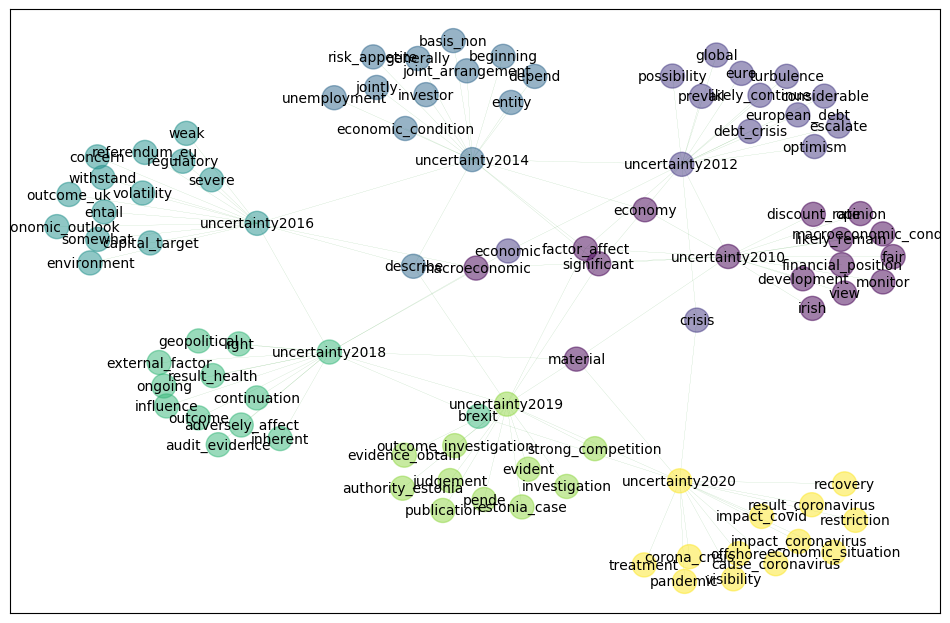

In [46]:
#%matplotlib qt 

g.plot()